## Load libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import unyt

import os
from glob import glob
from pathlib import Path

# For Swift Emulator training and validation
import swiftemulator as se
from swiftemulator.design import latin
from swiftemulator.io.swift import load_parameter_files
from swiftemulator.emulators import gaussian_process, gaussian_process_bins, gaussian_process_mcmc, gaussian_process_one_dim, linear_model, multi_gaussian_process
from swiftemulator.mean_models.polynomial import PolynomialMeanModel
from swiftemulator.sensitivity import basic, cross_check, cross_check_bins
from swiftemulator.mocking import mock_sweep


# For reading in simulation observables as Velociraptor HDF5 files
from velociraptor.observations import load_observation, load_observations


# For saving emulator for later use
import dill

## Load simulated data (galaxy functions, scaling relations, ...)

In [453]:
snap_prefix = 'simba_s25n256'  # eg. 'simba_s12.5n128'

# Main directory where calibration runs have been performed
root_dir = '/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s25n256_ps2020_sphenix_32x'

# Subdirectory that holds actual calibration runs
cali_dir = 'calibrations'

# Name of simulation observable
obs_name = 'gsmf_v4_log_data_0015'  # eg. 'gsmf'
# obs_name = 'bhmsm_v4_binned_log_median_0015'  # eg. 'gsmf'
# obs_name = 'bhmsm_v4_kh13_log_fit_0015'  # eg. 'gsmf'
# obs_name = 'csfh_log_data'  # eg. 'gsmf'

In [454]:
sim_paths = [Path(x) for x in glob(os.path.join(root_dir, cali_dir, 'cali_*', snap_prefix+'_'+obs_name+'.hdf5')) 
             if os.path.exists(x)]
cali_dirs = [Path(x) for x in glob(os.path.join(root_dir, cali_dir, 'cali_*')) 
             if os.path.exists(os.path.join(x, snap_prefix+'_'+obs_name+'.hdf5'))]
cali_dirnames = {dirname.stem: dirname for dirname in cali_dirs}
cali_list = [dirname.stem for dirname in cali_dirs]
# print(sim_paths)
# print(cali_list)
print(len(cali_list))

32


In [455]:
sim_dict = {}
thin = 1

for cali, sim_path in zip(cali_list, sim_paths):
    print(cali)
    sim_file = sim_path
#     sim_data = load_observations(sim_file)[0]
    
    try:
        sim_data = load_observations(sim_file)[0]
    except:
        print('Failed')
        continue

    # Load simulation observable data
    
    x_ = sim_data.x.value
    y_ = sim_data.y.value
    y_err_ = sim_data.y_scatter.value

    
    # Sanitize data of -inf, +inf, NaN values
    # Data for different simulations may have different array lengths
    isfinite = np.isfinite(x_)
    isfinite_err = np.resize(isfinite, np.shape(y_err_))
    x_ = x_[isfinite]
    y_ = y_[isfinite]
    y_err_copy = y_err_[isfinite_err]
    if (y_err_copy.ndim != y_err_.ndim):
        y_err_ = y_err_copy.reshape(y_err_.ndim, -1)
    else:
        y_err_ = y_err_copy
    

    isfinite = np.isfinite(y_)
    isfinite_err = np.resize(isfinite, np.shape(y_err_))
    x_ = x_[isfinite]
    y_ = y_[isfinite]
    y_err_copy = y_err_[isfinite_err]
    if (y_err_copy.ndim != y_err_.ndim):
        y_err_ = y_err_copy.reshape(y_err_.ndim, -1)
    else:
        y_err_ = y_err_copy
    
    
    # Get 1D errors
    y_err_arr = np.array(y_err_)
    if (y_err_arr.ndim!=1):
        mean_y_err_ = np.nanmean(y_err_arr, axis=0)
        max_y_err_ = np.nanmax(y_err_arr, axis=0)
    else:
        mean_y_err_ = y_err_arr
        max_y_err_ = y_err_arr
    
    
    sim_dict[cali] = {'x':x_[::thin], 'y':y_[::thin],
                      'y_err':y_err_, 'mean_y_err':mean_y_err_[::thin], 'max_y_err':max_y_err_[::thin], 
                      'sim_data':sim_data}

cali_0018
cali_0002
cali_0030
cali_0000
cali_0004
cali_0019
cali_0007
cali_0015
cali_0003
cali_0012
cali_0022
cali_0009
cali_0029
cali_0026
cali_0016
cali_0011
cali_0017
cali_0008
cali_0023
cali_0010
cali_0021
cali_0031
cali_0025
cali_0024
cali_0013
cali_0005
cali_0027
cali_0028
cali_0001
cali_0020
cali_0006
cali_0014


In [456]:
sim_data = load_observations(sim_file)[0]
sim_info = {
    'X_LABEL':sim_data.x_description,
    'Y_LABEL':sim_data.y_description,
    'name':sim_data.name,
    'x_units':sim_data.x_units,
    'y_units':sim_data.y_units,
    'comment':sim_data.comment,
    'z':sim_data.redshift,
    'z_lo':sim_data.redshift_lower,
    'z_hi':sim_data.redshift_upper,
    'plot_as':sim_data.plot_as,
}

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.07145494  6.12097447  7.17049399  8.22001352  9.26953305 10.31905257
 11.3685721  12.41809163 13.46761116 14.51713068]
yerr:  [0.46119658 0.36543499 0.27234732 0.18599271 0.12166922 0.12166922
 0.18599271 0.27234732 0.36543499 0.46119658]


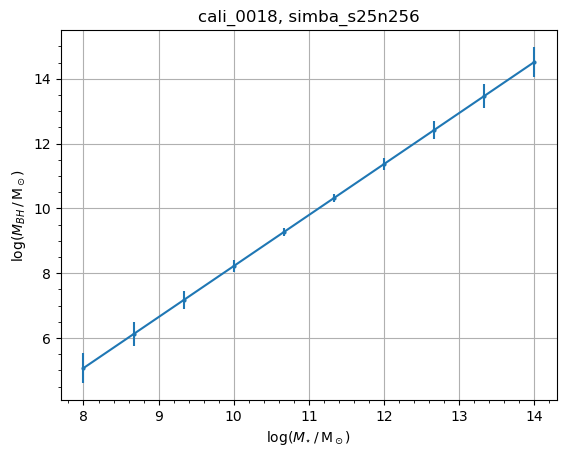

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 1.51269281  3.12068473  4.72867666  6.33666859  7.94466052  9.55265244
 11.16064437 12.7686363  14.37662823 15.98462016]
yerr:  [0.52310986 0.41258314 0.30440194 0.20236354 0.12286674 0.12286674
 0.20236354 0.30440194 0.41258314 0.52310986]


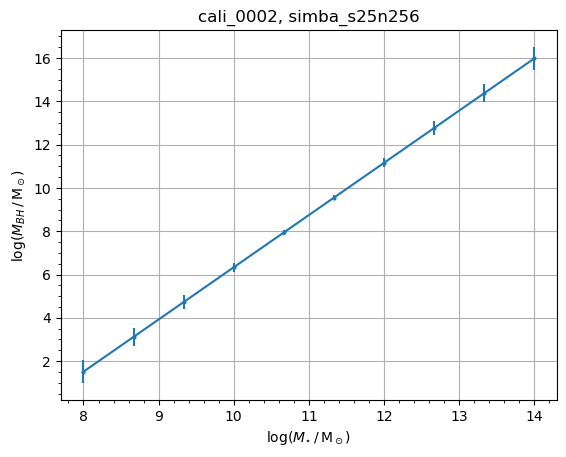

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.21097088  6.04930218  6.88763348  7.72596478  8.56429608  9.40262738
 10.24095868 11.07928998 11.91762129 12.75595259]
yerr:  [0.13736409 0.10833687 0.07992413 0.05312116 0.03223125 0.03223125
 0.05312116 0.07992413 0.10833687 0.13736409]


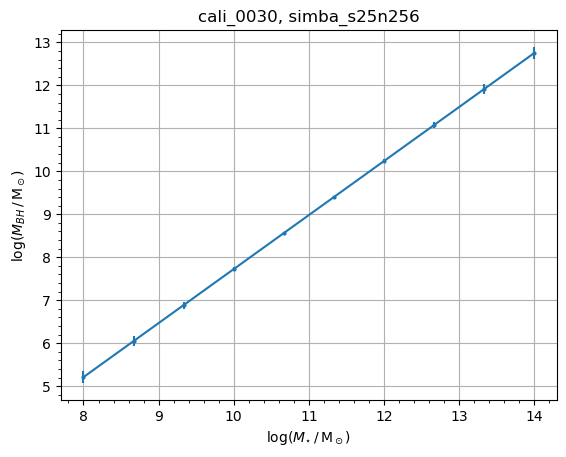

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 4.86932368  5.89816992  6.92701617  7.95586241  8.98470866 10.0135549
 11.04240115 12.07124739 13.10009364 14.12893988]
yerr:  [0.44695262 0.35416609 0.26397698 0.18032563 0.11804269 0.11804269
 0.18032563 0.26397698 0.35416609 0.44695262]


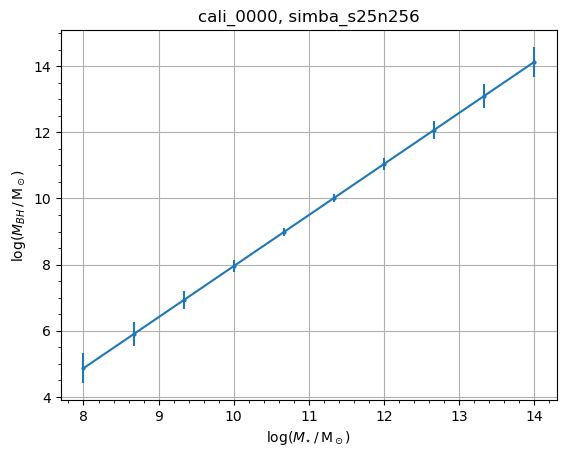

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.15412983  6.06219772  6.97026562  7.87833351  8.7864014   9.69446929
 10.60253718 11.51060507 12.41867296 13.32674086]
yerr:  [0.3433565  0.27162045 0.20171925 0.13650145 0.08719887 0.08719887
 0.13650145 0.20171925 0.27162045 0.3433565 ]


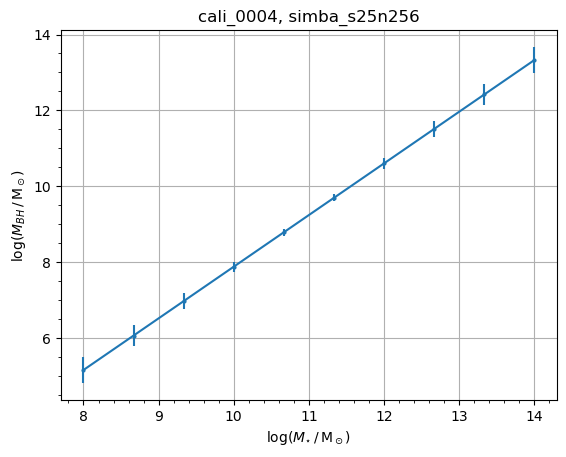

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 6.08216472  6.7975204   7.51287609  8.22823177  8.94358746  9.65894314
 10.37429882 11.08965451 11.80501019 12.52036588]
yerr:  [0.20337311 0.16016699 0.11778411 0.07758554 0.04574633 0.04574633
 0.07758554 0.11778411 0.16016699 0.20337311]


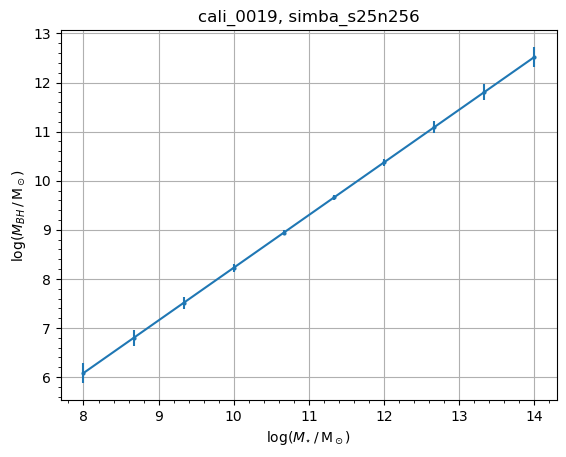

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 4.48637569  5.52414602  6.56191635  7.59968668  8.63745701  9.67522734
 10.71299767 11.75076799 12.78853832 13.82630865]
yerr:  [0.65266019 0.51644924 0.38377818 0.260121   0.16688787 0.16688787
 0.260121   0.38377818 0.51644924 0.65266019]


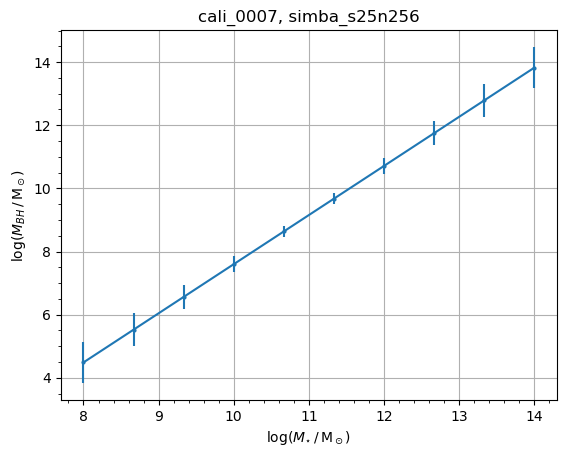

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 6.22418432  6.89036623  7.55654813  8.22273003  8.88891193  9.55509384
 10.22127574 10.88745764 11.55363954 12.21982145]
yerr:  [0.2037174  0.16024362 0.11752    0.07680867 0.04408948 0.04408948
 0.07680867 0.11752    0.16024362 0.2037174 ]


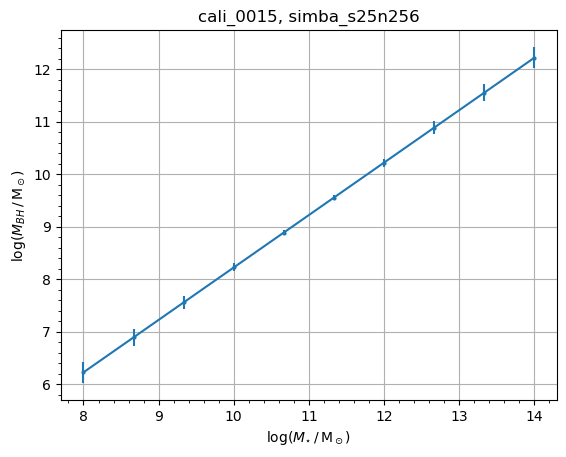

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 3.64091537  4.853529    6.06614263  7.27875626  8.49136989  9.70398352
 10.91659715 12.12921077 13.3418244  14.55443803]
yerr:  [0.35400479 0.27996662 0.20779256 0.1403877  0.08929829 0.08929829
 0.1403877  0.20779256 0.27996662 0.35400479]


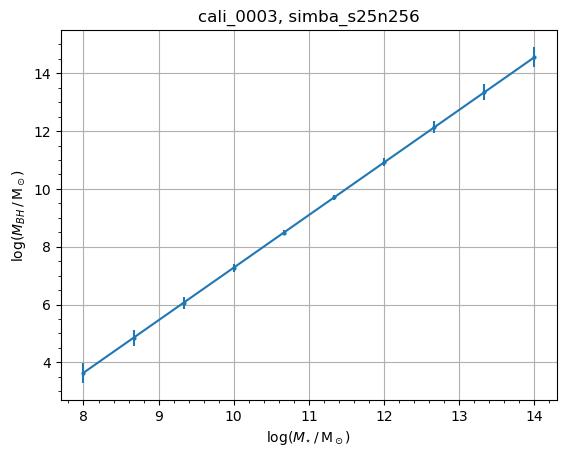

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 6.1065661   6.81719952  7.52783295  8.23846637  8.9490998   9.65973322
 10.37036664 11.08100007 11.79163349 12.50226692]
yerr:  [0.31488951 0.24810394 0.18263539 0.12064728 0.07180395 0.07180395
 0.12064728 0.18263539 0.24810394 0.31488951]


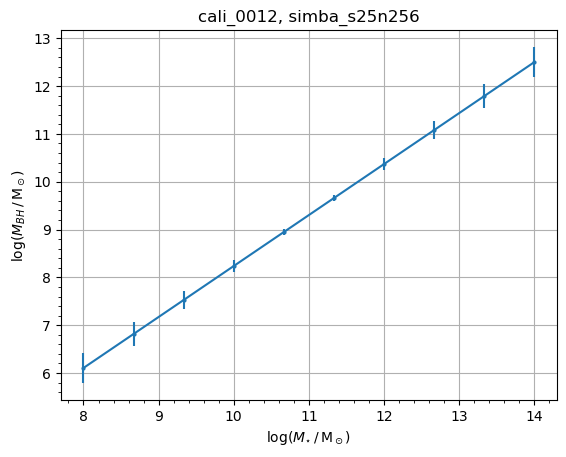

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.8532072   6.6434434   7.43367959  8.22391578  9.01415197  9.80438816
 10.59462435 11.38486055 12.17509674 12.96533293]
yerr:  [0.17143577 0.13529844 0.09996125 0.06670811 0.04097357 0.04097357
 0.06670811 0.09996125 0.13529844 0.17143577]


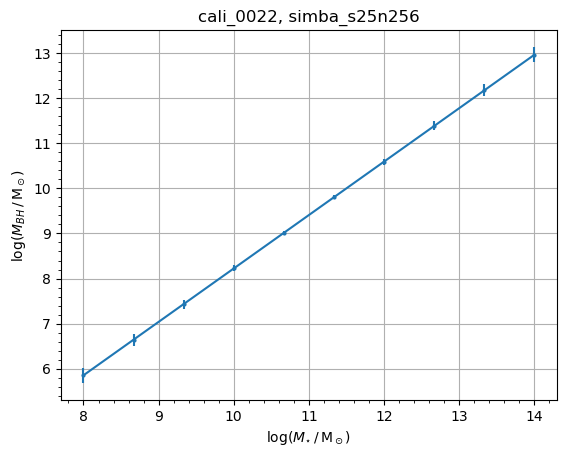

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 4.2276096   5.48192273  6.73623586  7.99054899  9.24486212 10.49917525
 11.75348838 13.0078015  14.26211463 15.51642776]
yerr:  [1.26097954 0.99803399 0.74200652 0.50356221 0.32415352 0.32415352
 0.50356221 0.74200652 0.99803399 1.26097954]


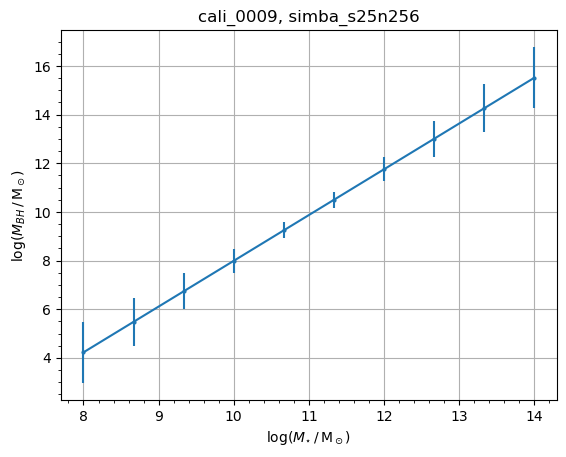

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 3.5599096   4.7336127   5.90731579  7.08101889  8.25472199  9.42842508
 10.60212818 11.77583128 12.94953437 14.12323747]
yerr:  [0.31650686 0.24937905 0.18357533 0.12127061 0.07217957 0.07217957
 0.12127061 0.18357533 0.24937905 0.31650686]


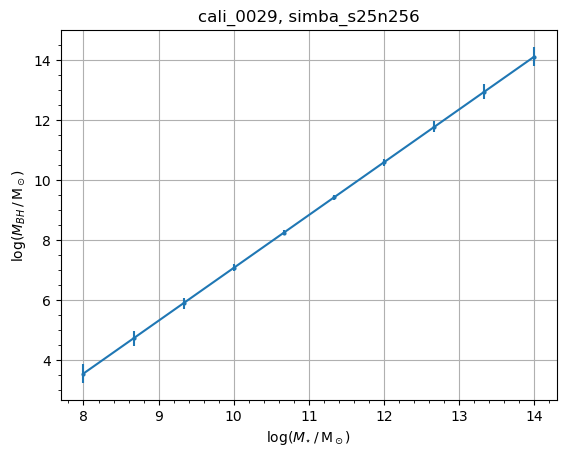

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.32224323  6.21729829  7.11235336  8.00740842  8.90246348  9.79751855
 10.69257361 11.58762867 12.48268374 13.3777388 ]
yerr:  [0.30766589 0.2433355  0.18063103 0.12208401 0.07773656 0.07773656
 0.12208401 0.18063103 0.2433355  0.30766589]


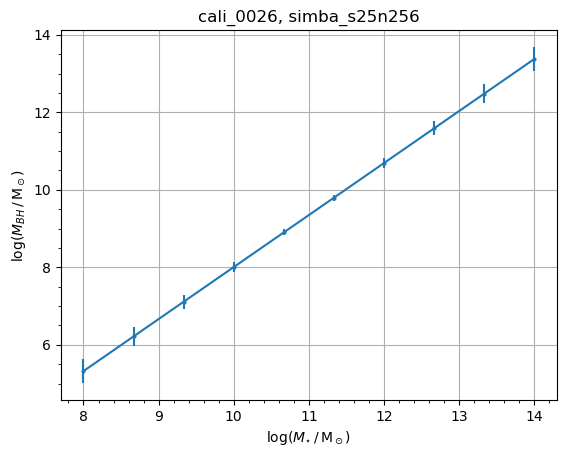

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.10974671  6.03166635  6.95358598  7.87550562  8.79742526  9.7193449
 10.64126453 11.56318417 12.48510381 13.40702345]
yerr:  [0.64058955 0.50567511 0.37379348 0.24979538 0.15406433 0.15406433
 0.24979538 0.37379348 0.50567511 0.64058955]


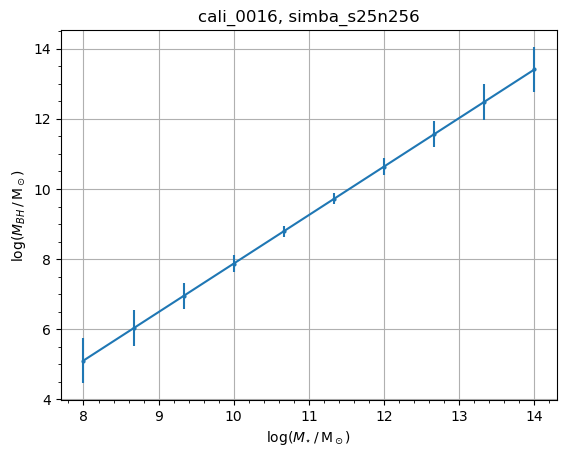

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 4.55403241  5.54737365  6.5407149   7.53405615  8.52739739  9.52073864
 10.51407989 11.50742114 12.50076238 13.49410363]
yerr:  [0.20766159 0.16384279 0.12097644 0.0805969  0.04925586 0.04925586
 0.0805969  0.12097644 0.16384279 0.20766159]


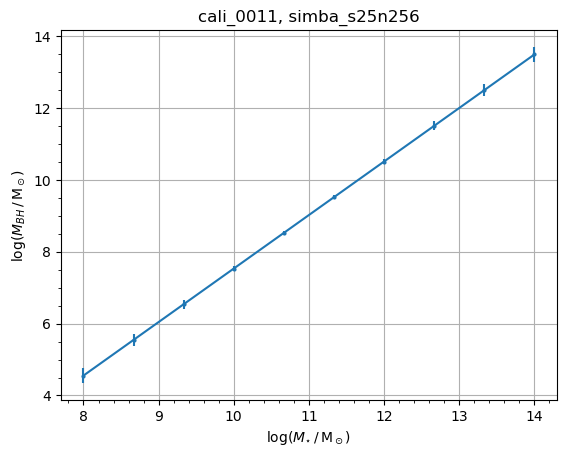

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.01208862  6.00514047  6.99819231  7.99124416  8.98429601  9.97734786
 10.9703997  11.96345155 12.9565034  13.94955525]
yerr:  [0.90173258 0.71219433 0.52706271 0.35333363 0.21993052 0.21993052
 0.35333363 0.52706271 0.71219433 0.90173258]


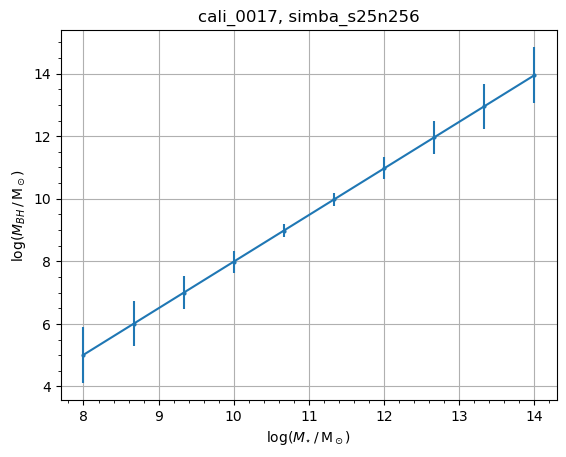

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 4.45718896  5.45651431  6.45583966  7.45516501  8.45449035  9.4538157
 10.45314105 11.4524664  12.45179175 13.4511171 ]
yerr:  [0.20174436 0.15910087 0.1173555  0.07796449 0.04723915 0.04723915
 0.07796449 0.1173555  0.15910087 0.20174436]


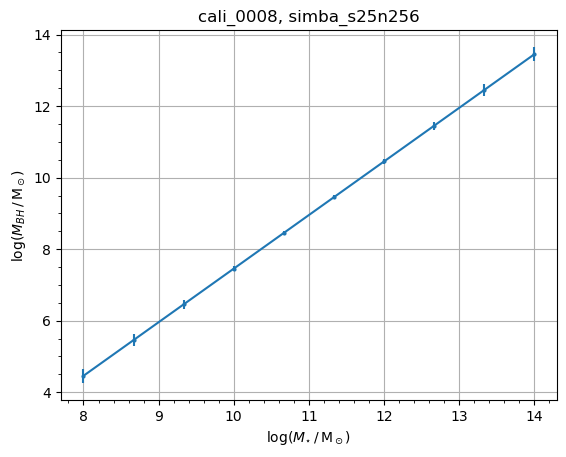

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 4.9070508   5.84011441  6.77317802  7.70624163  8.63930524  9.57236884
 10.50543245 11.43849606 12.37155967 13.30462328]
yerr:  [0.32236495 0.25409517 0.18721179 0.12397924 0.07437844 0.07437844
 0.12397924 0.18721179 0.25409517 0.32236495]


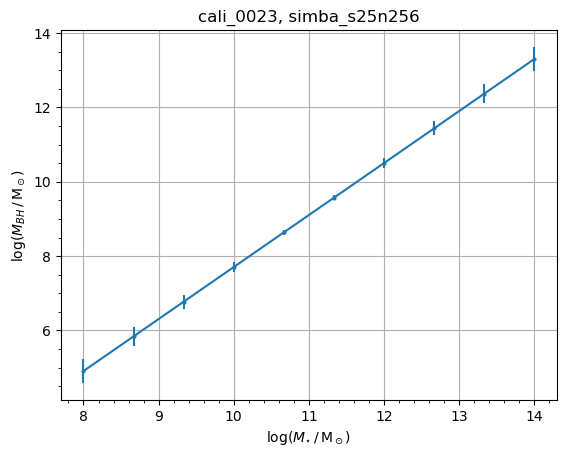

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 3.56504748  4.71772994  5.8704124   7.02309486  8.17577731  9.32845977
 10.48114223 11.63382469 12.78650714 13.9391896 ]
yerr:  [0.26323549 0.20767365 0.15331311 0.10209123 0.06230148 0.06230148
 0.10209123 0.15331311 0.20767365 0.26323549]


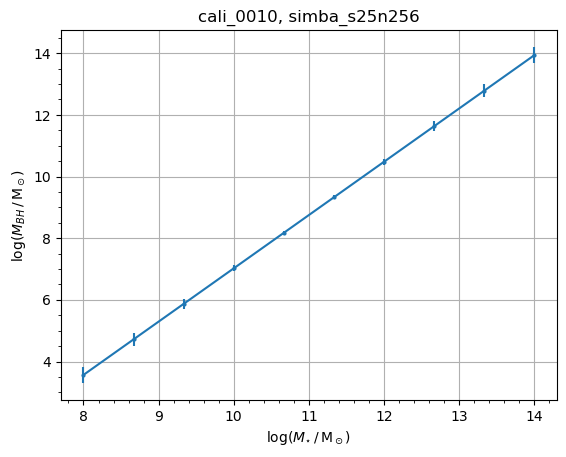

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 4.51141245  5.5540653   6.59671814  7.63937098  8.68202382  9.72467666
 10.7673295  11.80998235 12.85263519 13.89528803]
yerr:  [0.56651852 0.44862526 0.33392464 0.22730236 0.14746766 0.14746766
 0.22730236 0.33392464 0.44862526 0.56651852]


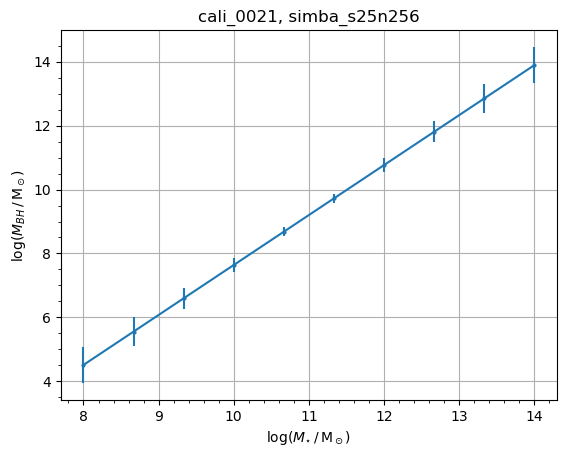

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.86597086  6.68524853  7.5045262   8.32380387  9.14308154  9.96235921
 10.78163688 11.60091455 12.42019222 13.23946989]
yerr:  [0.47072188 0.37253521 0.27692062 0.18784761 0.12077902 0.12077902
 0.18784761 0.27692062 0.37253521 0.47072188]


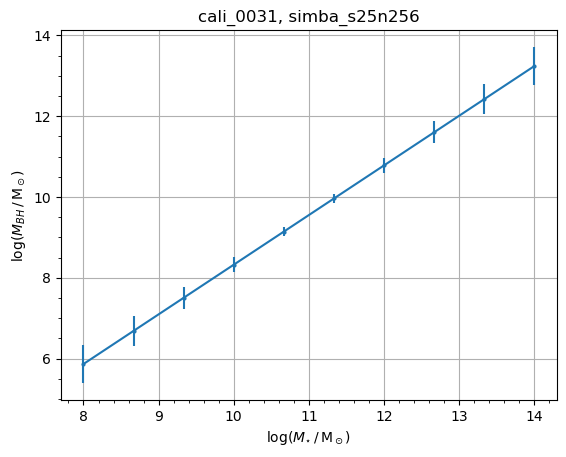

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [-2.36588495 -0.1391138   2.08765735  4.3144285   6.54119965  8.7679708
 10.99474195 13.22151309 15.44828424 17.67505539]
yerr:  [0.4571276  0.35947233 0.26346042 0.17186841 0.09799197 0.09799197
 0.17186841 0.26346042 0.35947233 0.4571276 ]


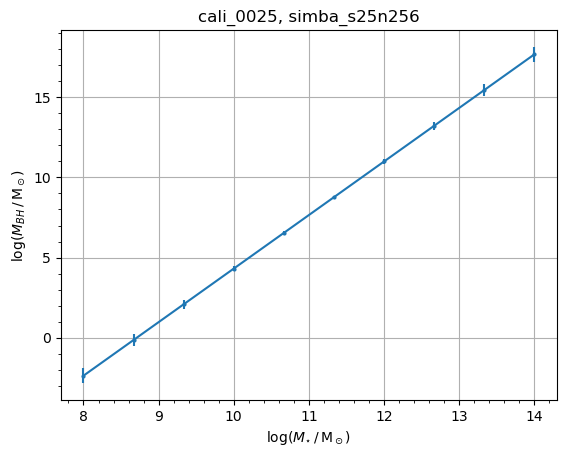

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.06821568  6.03168554  6.9951554   7.95862526  8.92209512  9.88556498
 10.84903484 11.8125047  12.77597456 13.73944442]
yerr:  [0.65128758 0.51473475 0.38148934 0.25675337 0.16160562 0.16160562
 0.25675337 0.38148934 0.51473475 0.65128758]


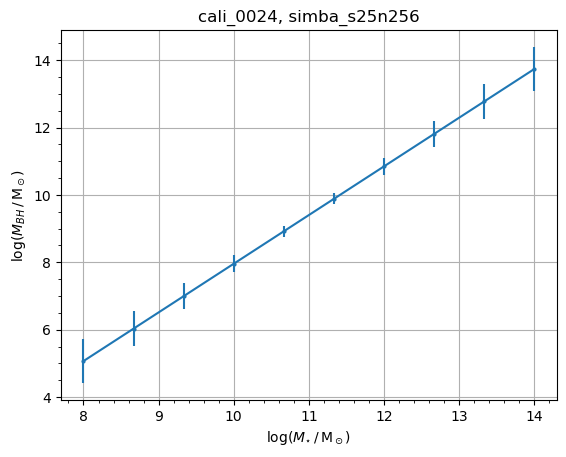

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.06339424  6.07569766  7.08800107  8.10030449  9.11260791 10.12491132
 11.13721474 12.14951816 13.16182157 14.17412499]
yerr:  [0.20889663 0.16550005 0.12330699 0.08414776 0.05494507 0.05494507
 0.08414776 0.12330699 0.16550005 0.20889663]


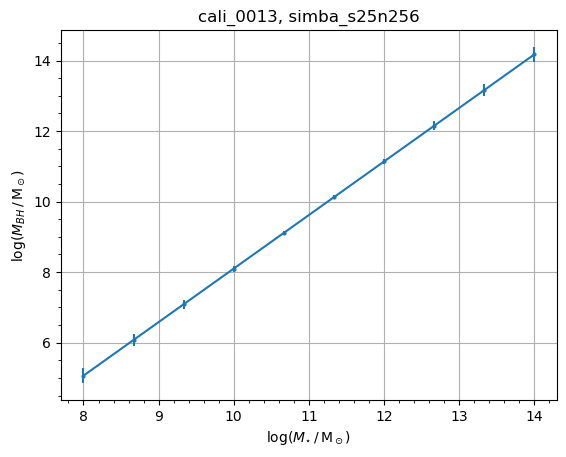

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 2.73768593  4.05097789  5.36426984  6.6775618   7.99085376  9.30414571
 10.61743767 11.93072963 13.24402158 14.55731354]
yerr:  [0.32504572 0.25627085 0.18891736 0.12529877 0.07553004 0.07553004
 0.12529877 0.18891736 0.25627085 0.32504572]


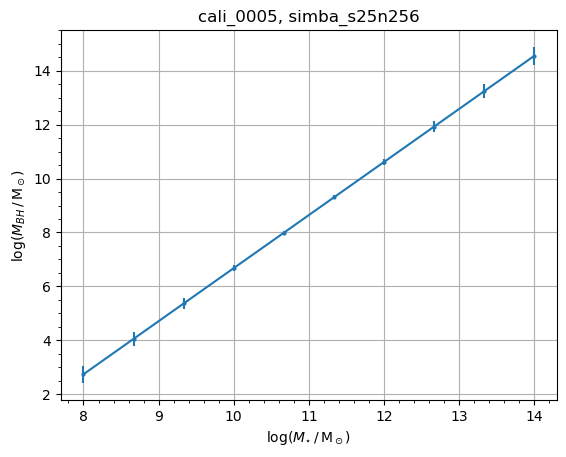

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.43266622  6.31261324  7.19256026  8.07250728  8.9524543   9.83240133
 10.71234835 11.59229537 12.47224239 13.35218941]
yerr:  [0.36206153 0.28610141 0.21196254 0.14251615 0.08945513 0.08945513
 0.14251615 0.21196254 0.28610141 0.36206153]


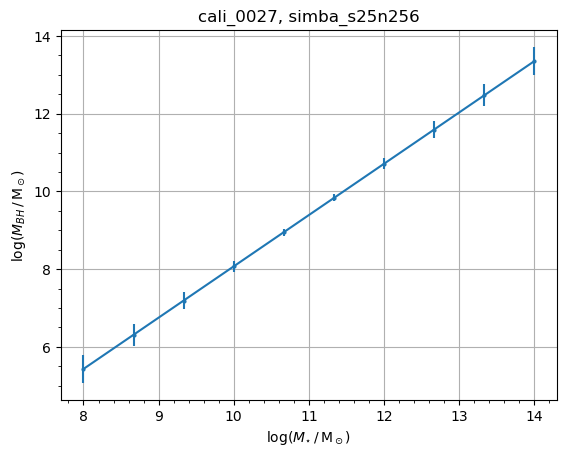

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.6920586   6.6206318   7.549205    8.47777819  9.40635139 10.33492458
 11.26349778 12.19207098 13.12064417 14.04921737]
yerr:  [0.31307906 0.247928   0.1845417  0.12562061 0.08150453 0.08150453
 0.12562061 0.1845417  0.247928   0.31307906]


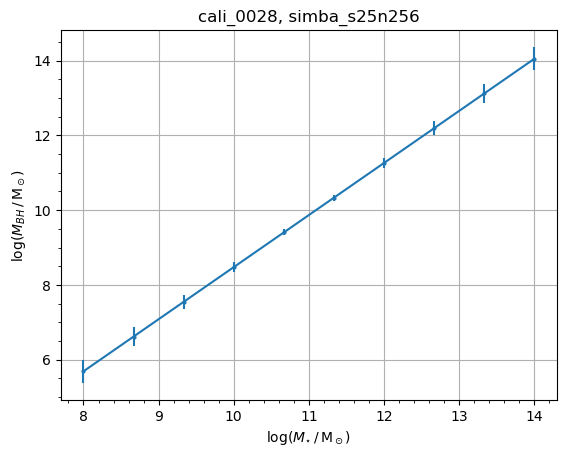

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.21294181  6.26072052  7.30849924  8.35627795  9.40405667 10.45183539
 11.4996141  12.54739282 13.59517154 14.64295025]
yerr:  [0.5118008  0.40577587 0.30280283 0.20747663 0.13683951 0.13683951
 0.20747663 0.30280283 0.40577587 0.5118008 ]


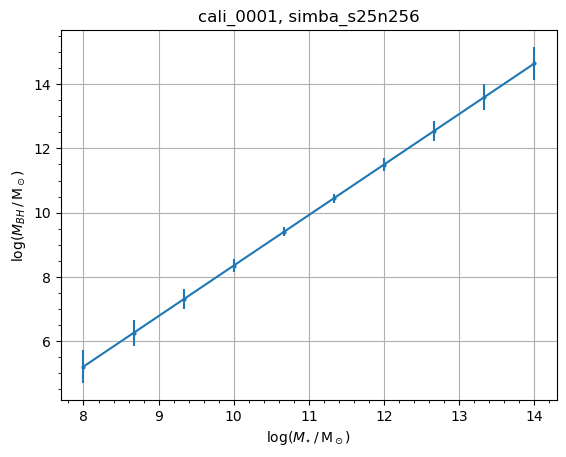

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.70838177  6.51434915  7.32031653  8.12628392  8.9322513   9.73821868
 10.54418607 11.35015345 12.15612084 12.96208822]
yerr:  [0.1467799  0.11574035 0.08534897 0.05665854 0.03425    0.03425
 0.05665854 0.08534897 0.11574035 0.1467799 ]


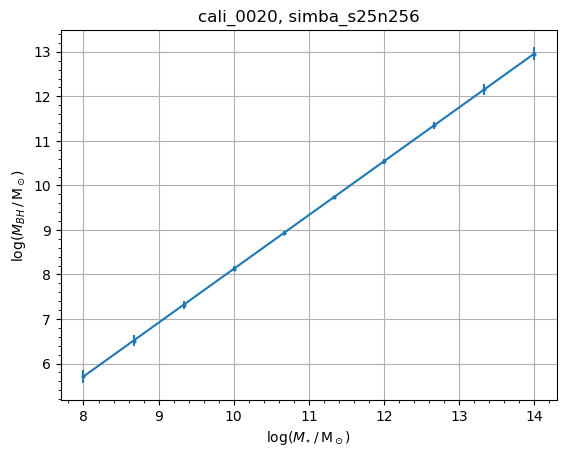

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.02598005  5.95873535  6.89149064  7.82424594  8.75700123  9.68975653
 10.62251183 11.55526712 12.48802242 13.42077771]
yerr:  [0.37837562 0.29960318 0.22295187 0.1516724  0.09824971 0.09824971
 0.1516724  0.22295187 0.29960318 0.37837562]


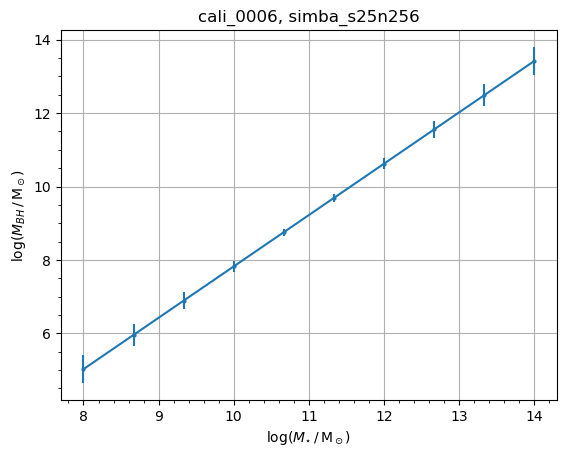

x:  [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.         12.66666667 13.33333333 14.        ]
y:  [ 5.23562386  6.18646042  7.13729697  8.08813353  9.03897008  9.98980664
 10.9406432  11.89147975 12.84231631 13.79315286]
yerr:  [0.36300752 0.287392   0.21379648 0.14532305 0.09393463 0.09393463
 0.14532305 0.21379648 0.287392   0.36300752]


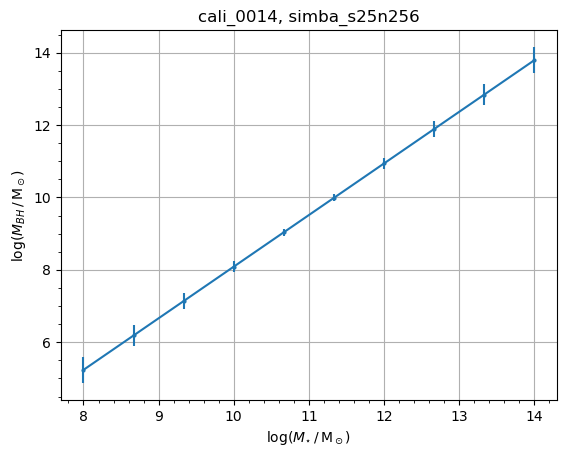

In [457]:
# Plot the observable to check it worked

thin_ = 1
# thin_ = 1000 # for CSFH

for cali in sim_dict:
    print("x: ", sim_dict[cali]['x'])
    print("y: ", sim_dict[cali]['y'])
    print("yerr: ", sim_dict[cali]['max_y_err'])    
    
    plt.clf()
    plt.xlabel(sim_info['X_LABEL'])
    plt.ylabel(sim_info['Y_LABEL'])
    plt.title(r'%s, %s' % (cali, snap_prefix))
    plt.grid()
    plt.minorticks_on()
    plt.errorbar(sim_dict[cali]['x'][::thin_], sim_dict[cali]['y'][::thin_], yerr=sim_dict[cali]['max_y_err'][::thin_], 
                 fmt='o-', markersize=2)
    plt.show()

## Specify the model parameters and values

In [458]:
parameter_files = [Path(os.path.join(cali_dir, cali+'.yml')) for cali_dir, cali in zip(cali_dirs, cali_list)]
parameter_filenames = {filename.stem: filename for filename in parameter_files}

In [459]:
model_specification, model_parameters = load_parameter_files(
    filenames=parameter_filenames,
    parameters=[
        "SIMBAFeedback:FIRE_velocity_normalization",
        "SIMBAAGN:torque_accretion_norm",
        "SIMBAAGN:jet_mass_min_Msun",
    ],
    log_parameters=[
        "SIMBAAGN:jet_mass_min_Msun",
    ],
    parameter_printable_names=[
        "$v_{a}$",
        "$\\varepsilon_{\\rm torque}$",
        "$\\log_{10}$ $M_{\\rm BH, lim}/M_{\\rm \odot}$",
    ],
)

In [479]:
modelvalues = {}

# GSMF
# min_x_for_emulator = 8.5  # Seems to be resolution limit
# max_x_for_emulator = 13
# min_x_for_emulator = 10
# max_x_for_emulator = 11.8

# Mbh-M*
min_x_for_emulator = 8.5
# min_x_for_emulator = 10
max_x_for_emulator = 13

# CSFH
# min_x_for_emulator = -1
# max_x_for_emulator = 5

# If too many data points, will take very long to train emulator and use emulator to predict values
thin_ = 1
# thin_ = 10000 # for CSHF

# rel_err = 0.02 # for Mbh-M*
rel_err = 0.05 # for CSFH

for cali in model_parameters.model_parameters:
    independent = sim_dict[cali]['x'][::thin_]
    dependent = sim_dict[cali]['y'][::thin_]
    
    # Must choose whether to specify own errorbars
    # or use maximum or mean errorbars (as swift emulator can only handle single value for errorbars)
#     dependent_error = np.abs(rel_err * dependent)
    dependent_error = sim_dict[cali]['max_y_err'][::thin_]
#    dependent_error = [0]*len(dependent)

    range_condition = np.logical_and(independent>=min_x_for_emulator, independent<=max_x_for_emulator)
    
    modelvalues[cali] = {"independent": independent[range_condition],
                         "dependent": dependent[range_condition],
                         "dependent_error": dependent_error[range_condition]}

model_values = se.ModelValues(model_values=modelvalues)

In [480]:
## To check if there are any x bin values appearing only once
## This can make errors pop up when training the emulator, doing the parameter sensitivity analysis
## and performing the cross-check validation

comb_ = np.array([])
for key, val in model_values.model_values.items():
#     print(np.all(np.isfinite(val['independent'])))
#     print(np.all(np.isfinite(val['dependent'])))
#     print(np.all(np.isfinite(val['dependent_error'])))
#     print(max(val['independent']))
    comb_ = np.concatenate((comb_, val['independent']))
#     comb_ = np.append(comb_, val['independent'])
#     comb_ = np.append(comb_, max(val['independent']))
    
# Find unique values and their counts
unique_values, counts = np.unique(comb_, return_counts=True)
print("Unique x values:", unique_values)
print("Number of times:", counts)

# Find values that appear only once
values_appearing_once = unique_values[counts == 1]

# Print the values that appear only once
print("x values appearing only once:", values_appearing_once)

Unique x values: [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
Number of times: [32 32 32 32 32 32 32]
x values appearing only once: []


## Model Parameter Features

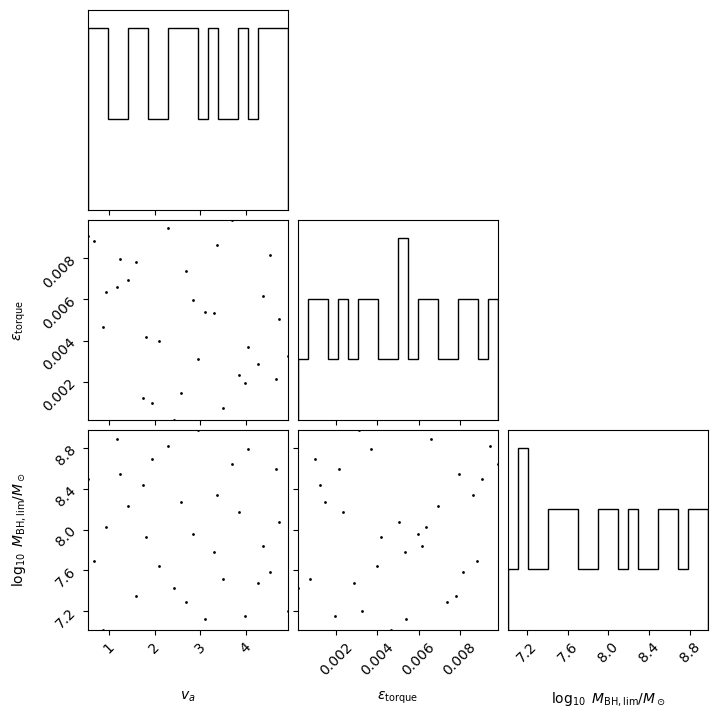

In [462]:
model_parameters.plot_model(model_specification)

## Train emulator

In [481]:
emulator = gaussian_process.GaussianProcessEmulator()  # Default
#emulator = gaussian_process_mcmc.GaussianProcessEmulatorMCMC(mcmc_steps=1000, burn_in_steps=1, walkers=40, use_hyperparameter_error=False)  # With MCMC
# emulator = gaussian_process_bins.GaussianProcessEmulatorBins()  # Gaussian Process Emulator using an emulator for each bins
#emulator = gaussian_process_one_dim.GaussianProcessEmulator1D()  # Gaussian Process Emulator for emulating single values
#emulator = linear_model.LinearModelEmulator(lasso_model_alpha=0)  # Linear Model Emulator
#emulator = multi_gaussian_process.MultipleGaussianProcessEmulator()  # A gaussian process emulator that uses _multiple_ internal emulators to better predict functions that contain a ‘break’.
#polynomial_model = PolynomialMeanModel(degree=2)  # Polynomial mean model
#emulator = gaussian_process.GaussianProcessEmulator(mean_model=polynomial_model)  # Mean model

emulator.fit_model(model_specification=model_specification,
                            model_parameters=model_parameters,
                            model_values=model_values)
emulator.model_specification.sim_info = sim_info

## Make predictions and compare

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.20136423  7.21072622  8.24171621  9.28125437 10.3153998  11.32965991
 12.30931669]
yerr:  [0.04387902 0.01874974 0.00880783 0.00553603 0.00561581 0.01064507
 0.02736767]
Slope:  [1.5140429944895404, 1.5464849817144297, 1.559307234011159, 1.5512181438066928, 1.521390166543382, 1.469485178382444]


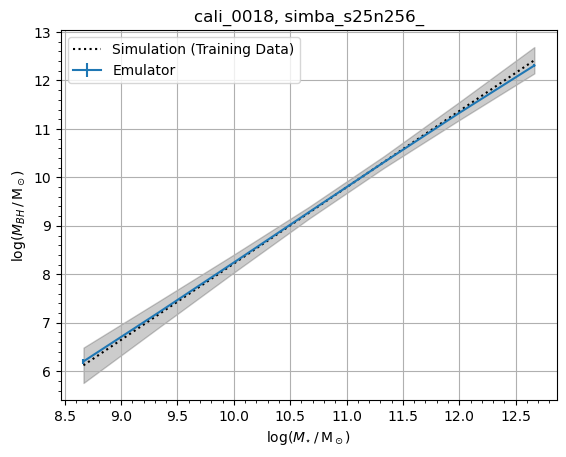

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 3.33739679  4.83901252  6.38665666  7.95942059  9.53517185 11.09107528
 12.60412853]
yerr:  [0.04952446 0.02229335 0.01026845 0.00583524 0.00603741 0.01224668
 0.03041796]
Slope:  [2.2524235859543214, 2.3214662110095454, 2.3591458955483113, 2.3636268902624757, 2.3338551506078953, 2.2695798711125392]


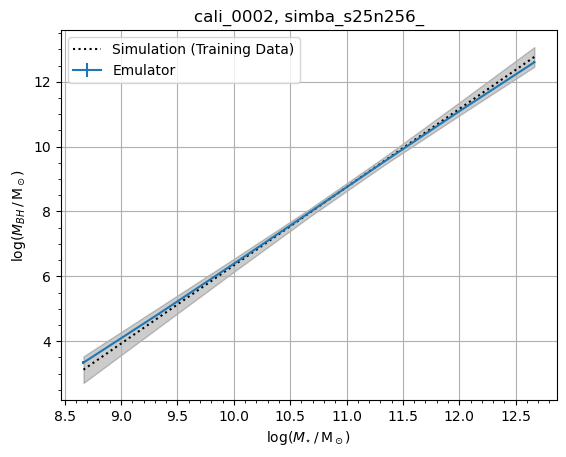

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.071602    6.88389116  7.71749143  8.56258606  9.40845344 10.24368752
 11.05644189]
yerr:  [0.00638725 0.00196991 0.00077858 0.00050817 0.00047585 0.00097728
 0.00369813]
Slope:  [1.218433747650122, 1.2504003989920147, 1.267641942778469, 1.2688010708998274, 1.252851130926222, 1.219131554020849]


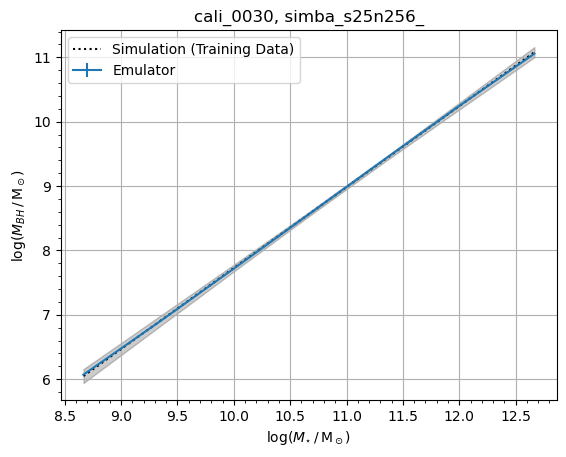

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 5.9255383   6.92802766  7.95354945  8.98898069 10.02031535 11.03297855
 12.0121582 ]
yerr:  [0.04219977 0.0180388  0.00842185 0.0052308  0.00531715 0.01019858
 0.02630272]
Slope:  [1.5037340519793405, 1.538282670797814, 1.5531468671697666, 1.5470019866070017, 1.51899480259197, 1.4687694759495122]


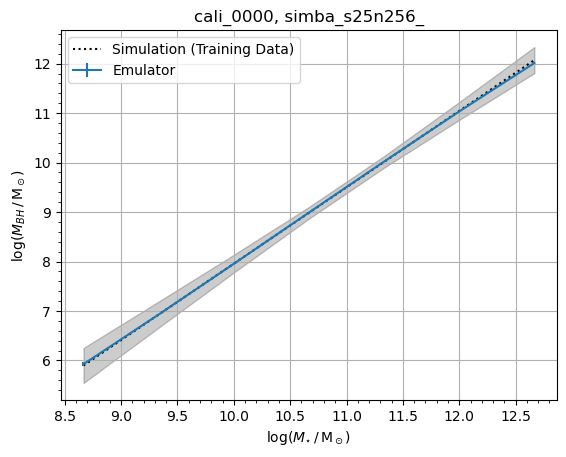

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.03205797  6.93020687  7.85073069  8.78225977  9.7125189  10.62859362
 11.51721744]
yerr:  [0.02177654 0.00938198 0.00449732 0.00283699 0.00288669 0.00535554
 0.01354358]
Slope:  [1.3472233528746618, 1.3807857406905426, 1.3972936088731855, 1.3953887011525885, 1.3741120822288029, 1.3329357301699762]


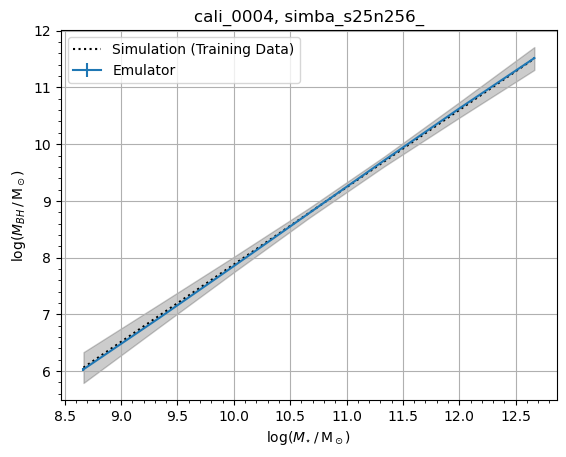

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.79787464  7.49901278  8.21641387  8.94187929  9.66636813 10.38017815
 11.07315132]
yerr:  [0.01134112 0.00390402 0.00157167 0.00096099 0.00092534 0.00196474
 0.00661019]
Slope:  [1.0517072115664643, 1.076101630428206, 1.088198126323399, 1.0867332716049356, 1.0707150205238614, 1.0394597510012824]


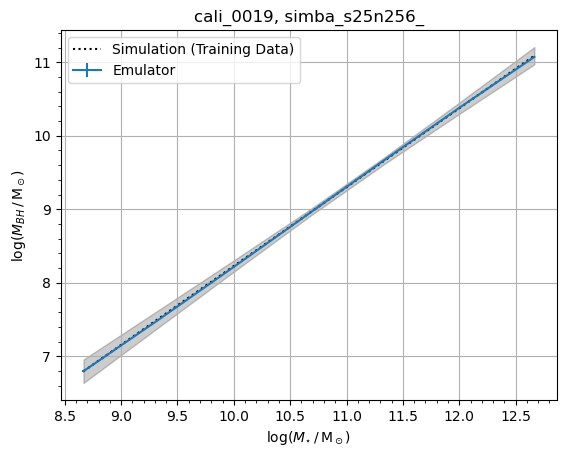

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 5.56589903  6.57071514  7.60088479  8.64286743  9.68220077 10.70383574
 11.69248909]
yerr:  [0.07017289 0.0322454  0.01586361 0.01000631 0.01028204 0.01879324
 0.04429179]
Slope:  [1.5072241707398115, 1.5452544731673412, 1.56297396228126, 1.5590000060627225, 1.5324524630647156, 1.482980023599159]


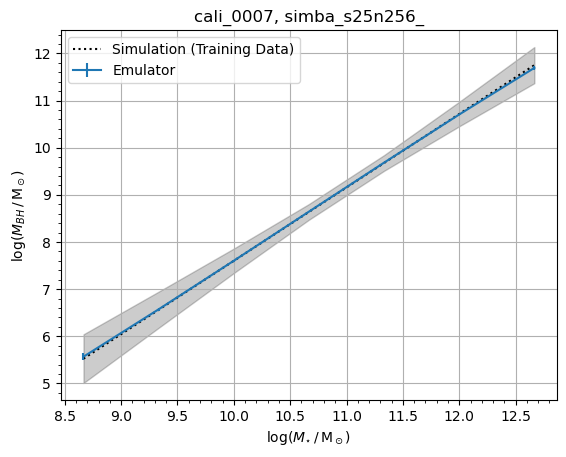

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.88039004  7.53672506  8.20801684  8.88655958  9.56382611 10.2306407
 10.87737671]
yerr:  [0.01237139 0.0040508  0.00154068 0.00094258 0.00089004 0.00197026
 0.00710362]
Slope:  [0.98450252612116, 1.0069376744947371, 1.0178141124186704, 1.0158997873493485, 1.0002218898331794, 0.9701040148370881]


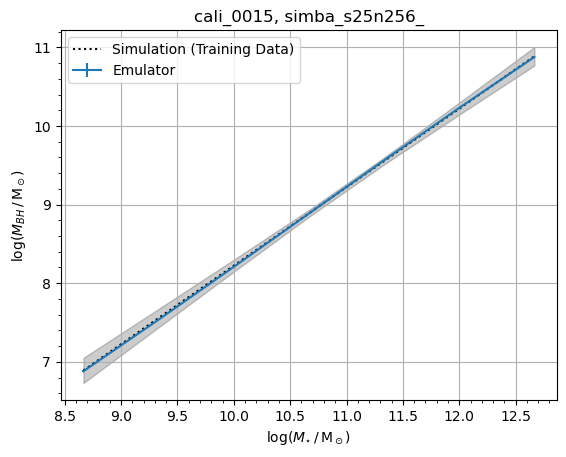

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 4.87189371  6.05292054  7.26464062  8.49103101  9.71509229 10.91924171
 12.08572118]
yerr:  [0.03018118 0.01161572 0.00510967 0.00325843 0.00320592 0.00628901
 0.01830687]
Slope:  [1.771540254370731, 1.8175801090371324, 1.8395855841377882, 1.836091931557499, 1.8062241274797626, 1.7497192022373669]


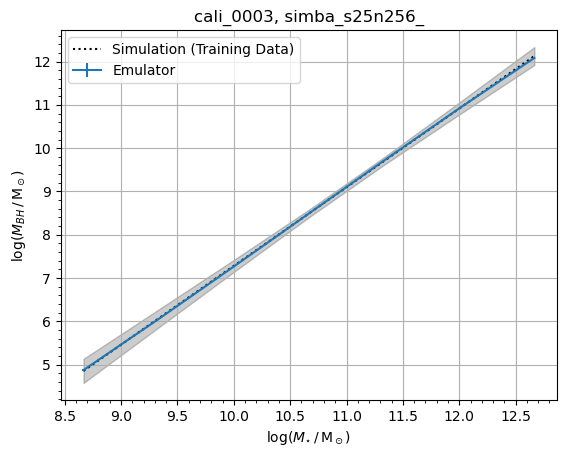

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.85412454  7.53948465  8.24133317  8.95165322  9.66156972 10.36152773
 11.04149632]
yerr:  [0.02147176 0.00837667 0.00362055 0.00216421 0.00215274 0.0044169
 0.01281564]
Slope:  [1.028040171272833, 1.0527727751974405, 1.0654800704310796, 1.0648747577207667, 1.0499370125296696, 1.0199528856884443]


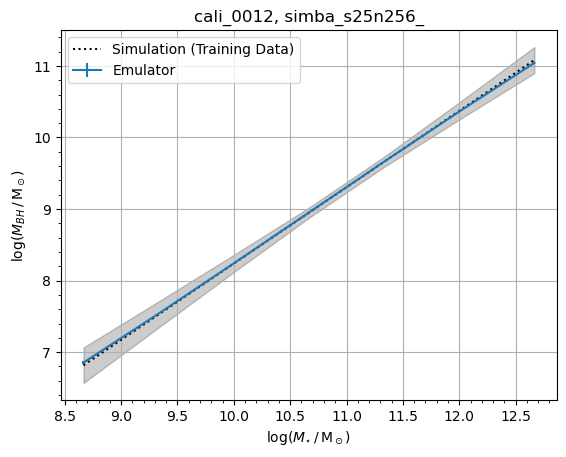

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.65464173  7.42392856  8.21232535  9.01125965  9.8112569  10.60211518
 11.37310618]
yerr:  [0.00710914 0.00261969 0.0011569  0.00070811 0.00070391 0.00139336
 0.00424237]
Slope:  [1.15393025647114, 1.1825951780554658, 1.1984014465496824, 1.199995881386344, 1.1862874213448238, 1.1564864997320161]


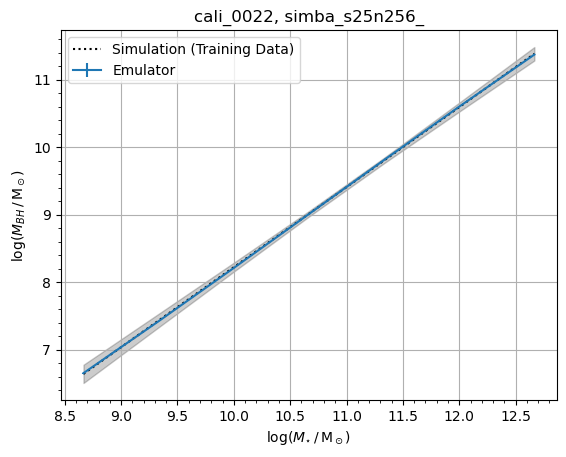

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 4.78394287  6.21510912  7.67803673  9.15288466 10.61888805 12.05484729
 13.43962393]
yerr:  [0.16631249 0.09228185 0.05172467 0.03431871 0.03599617 0.0588157
 0.11110187]
Slope:  [2.1467493736706547, 2.1943914147284875, 2.2122718994274084, 2.1990050820631097, 2.1539388560492028, 2.077164964428766]


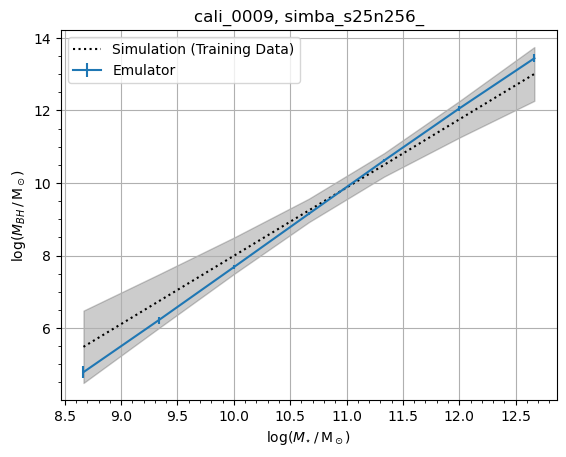

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 4.75582381  5.89416551  7.06437743  8.25132573  9.43885786 10.61016788
 11.74817943]
yerr:  [0.02418852 0.00903539 0.00376465 0.00226593 0.00222115 0.0046668
 0.01430379]
Slope:  [1.707512544164683, 1.7553178832834975, 1.780422444493256, 1.7812982051179842, 1.756965033365859, 1.707017325505525]


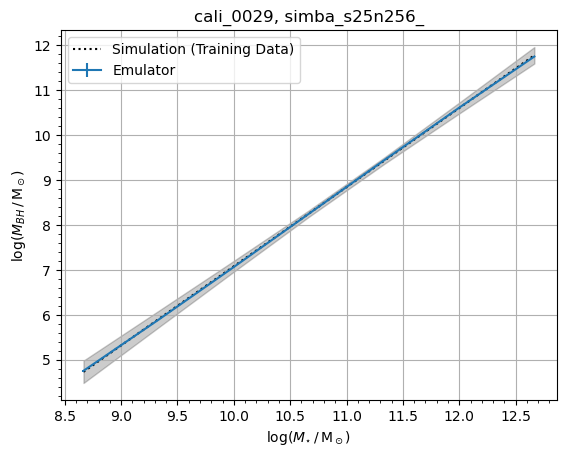

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.14885635  7.0425014   7.96007329  8.89028073  9.82086854 10.7388833
 11.63096253]
yerr:  [0.01948588 0.00784822 0.00364265 0.00234827 0.00234605 0.00438668
 0.01194945]
Slope:  [1.3404675794424012, 1.3763578303306345, 1.3953111683782011, 1.3958817057527297, 1.3770221390546606, 1.338118853749035]


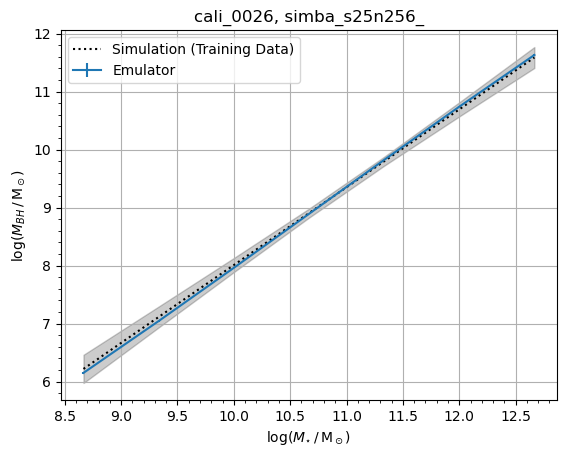

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 5.94271255  6.87015998  7.82220671  8.78642665  9.74944122 10.69722919
 11.61545727]
yerr:  [0.05032598 0.02572122 0.01339636 0.00833322 0.00871082 0.01540285
 0.03232019]
Slope:  [1.391171133874605, 1.4280701087321517, 1.4463299028035812, 1.4445218500512165, 1.421681956967091, 1.3773421247410176]


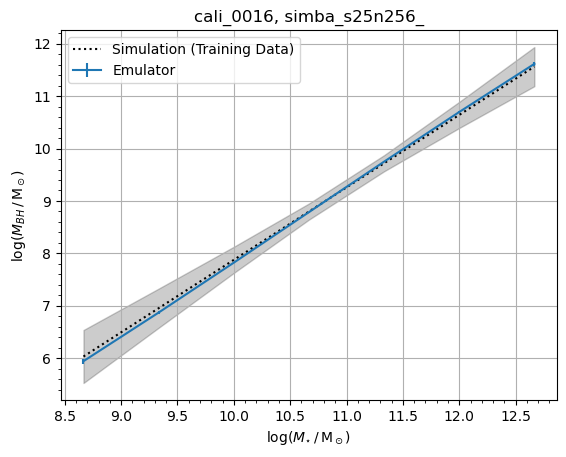

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 5.5761174   6.53467367  7.52125989  8.52367514  9.5286942  10.5223549
 11.49026897]
yerr:  [0.01056409 0.00391312 0.00169116 0.00103342 0.00102088 0.00206206
 0.00629248]
Slope:  [1.4378343996829104, 1.4798793320896677, 1.5036228714875022, 1.5075285919945585, 1.490491053715414, 1.4518711095076156]


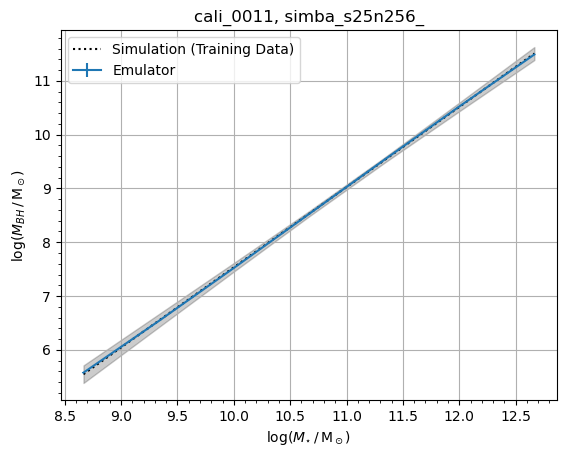

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 5.95752894  6.94388872  7.95512807  8.97801651  9.99837902 11.00142378
 11.97208918]
yerr:  [0.08281692 0.0424557  0.02366935 0.01646608 0.01689477 0.02685161
 0.05426509]
Slope:  [1.4795396631578557, 1.516859028753037, 1.5343326574010603, 1.530543762636705, 1.5045671424864162, 1.4559981048971742]


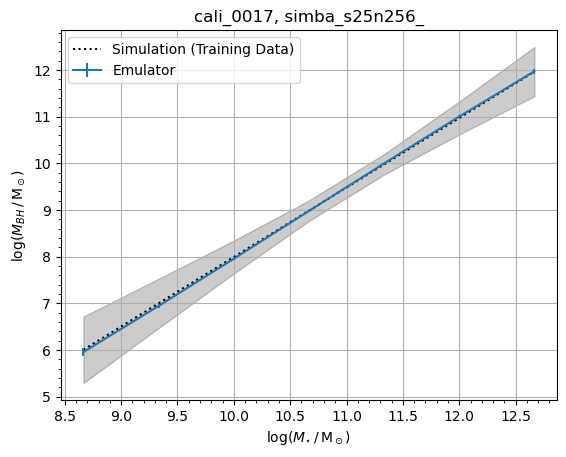

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 5.4886463   6.45426923  7.44696456  8.45373234  9.4605925  10.45290883
 11.41573352]
yerr:  [0.01235216 0.00405436 0.00160854 0.00104718 0.00098533 0.00203838
 0.00720774]
Slope:  [1.4484343848132317, 1.4890429989658212, 1.5101516787489877, 1.5102902277480692, 1.4884745004684676, 1.4442370365827029]


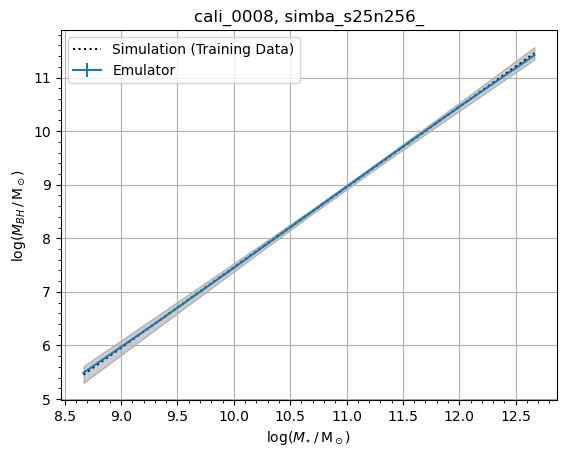

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 5.86555502  6.7717124   7.70053127  8.64030784  9.57844159 10.50171487
 11.39659247]
yerr:  [0.02646641 0.00965864 0.00397242 0.00243773 0.00236585 0.00496529
 0.01562673]
Slope:  [1.3592360628839775, 1.3932283036391282, 1.4096648552289905, 1.4072006287170793, 1.3849099213972853, 1.3423163997570609]


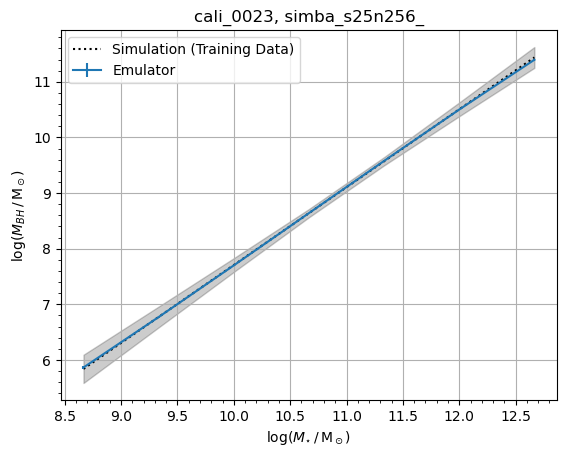

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 4.73231197  5.85101427  7.00185893  8.17005787  9.33979136 10.49456357
 11.61757687]
yerr:  [0.01618475 0.00607487 0.00262766 0.00163584 0.00160897 0.00321898
 0.00967177]
Slope:  [1.6780534546723487, 1.7262669852685606, 1.7522984076280694, 1.7546002366424698, 1.7321583143900727, 1.68451995224426]


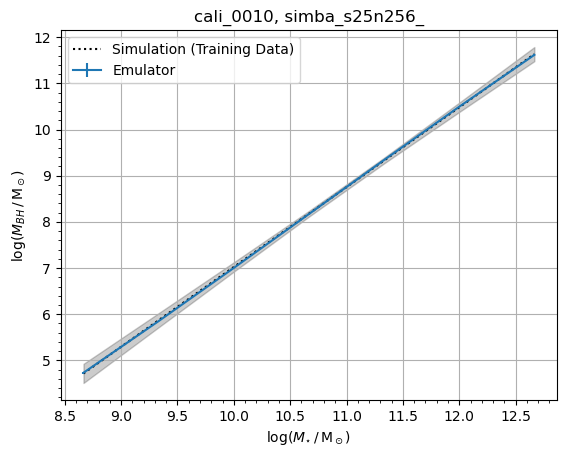

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 5.58050523  6.60482502  7.64773518  8.69484213  9.7310475  10.74091337
 11.70903588]
yerr:  [0.07371924 0.02976456 0.0134254  0.00853286 0.00849363 0.01646448
 0.04534687]
Slope:  [1.536479697296497, 1.5643652306735816, 1.5706604332236842, 1.5543080544959795, 1.5147987968120011, 1.452183773962998]


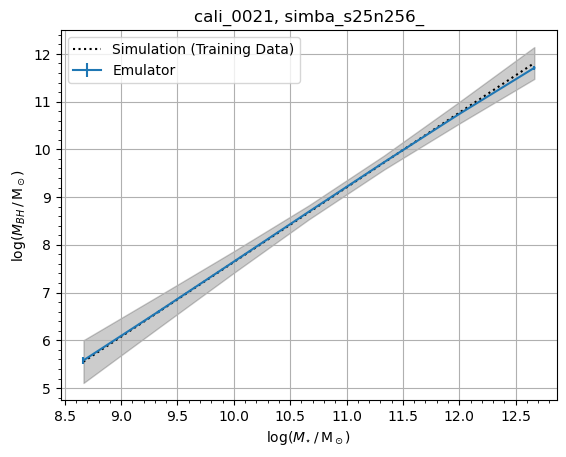

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.68805803  7.49127423  8.31327501  9.14363509  9.97105573 10.78362021
 11.56907118]
yerr:  [0.04442102 0.01904951 0.00889444 0.00550727 0.0055959  0.01072677
 0.02756343]
Slope:  [1.2048243121725775, 1.2330011666042051, 1.2455401093854175, 1.2411309686806036, 1.2188467206884082, 1.1781764567998378]


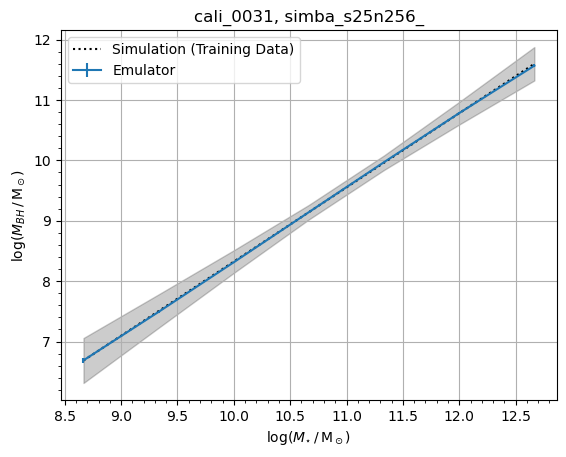

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 0.10873687  2.19809602  4.35629691  6.55300937  8.7564255  10.93403312
 13.05339415]
yerr:  [0.04207584 0.01715833 0.00731486 0.00408225 0.00411413 0.00888835
 0.02494784]
Slope:  [3.1340387221403403, 3.2373013370808392, 3.2950686938582296, 3.305124195183548, 3.2664114191973233, 3.179041546760664]


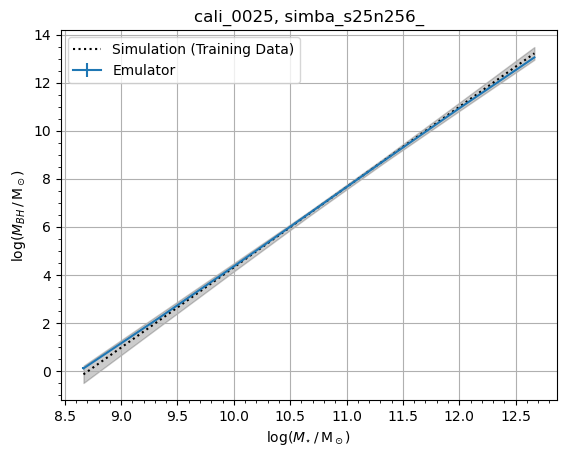

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.06934039  7.00284239  7.95989147  8.92874618  9.8967304  10.85050555
 11.77636453]
yerr:  [0.06054847 0.03017901 0.01522404 0.00919989 0.00964888 0.01776082
 0.03864719]
Slope:  [1.4002529982763694, 1.4355736187926538, 1.4532820670231756, 1.4519763180577114, 1.4306627361595805, 1.3887884608296743]


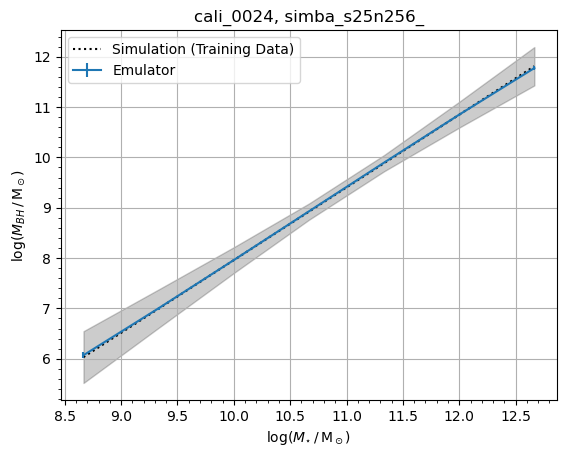

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.09856487  7.07890412  8.0865121   9.10918993 10.1337002  11.14604707
 12.13178114]
yerr:  [0.01255038 0.00440767 0.00191319 0.00129302 0.0012404  0.00236695
 0.00757116]
Slope:  [1.4705088751571838, 1.511411972700246, 1.5340167509809333, 1.5367653946244828, 1.5185203045980815, 1.478601105617821]


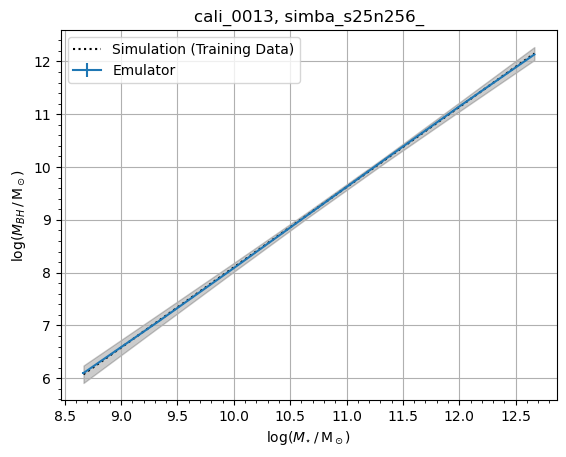

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 4.17423809  5.4167457   6.69654931  7.99680103  9.299548   10.58614566
 11.83768856]
yerr:  [0.02331658 0.00924182 0.00401287 0.00237157 0.00237233 0.00489323
 0.0139737 ]
Slope:  [1.8637614137064669, 1.9197054157622961, 1.9503775860519585, 1.954120452777227, 1.9298964930030078, 1.8773143525718412]


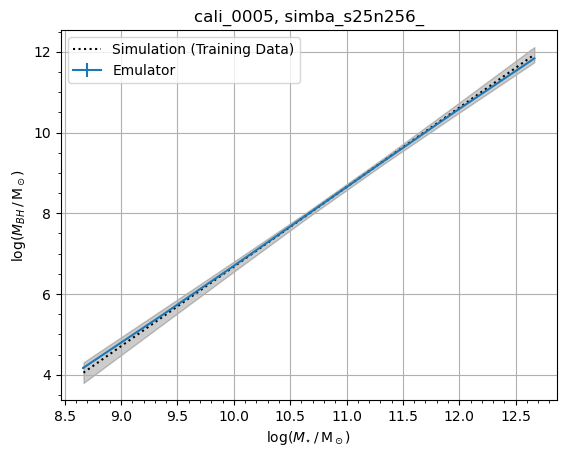

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.32390598  7.181592    8.06072201  8.95106817  9.84148556 10.7201367
 11.57473989]
yerr:  [0.02480309 0.01048339 0.00490997 0.00306449 0.00310143 0.00587818
 0.01527917]
Slope:  [1.286529025327153, 1.3186950146347851, 1.3355192465589465, 1.3356260786982361, 1.31797671199156, 1.281904778991467]


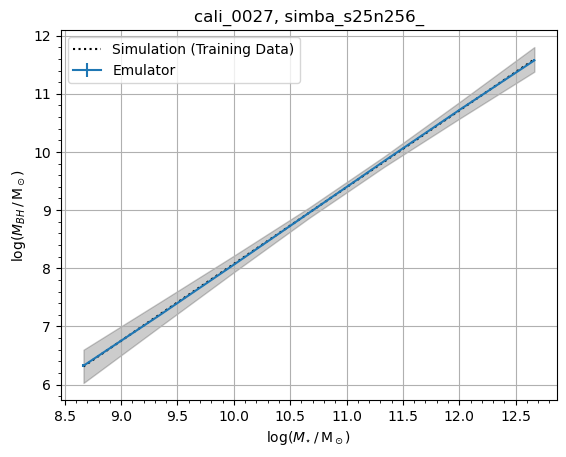

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.62381807  7.53697656  8.46999636  9.41055427 10.34546206 11.26097556
 12.14312235]
yerr:  [0.02813181 0.00988033 0.00419547 0.00287228 0.00272617 0.00526236
 0.01693753]
Slope:  [1.3697377404358424, 1.3995296902304672, 1.4108368744502697, 1.4023616833828796, 1.3732702406616906, 1.3232201900288107]


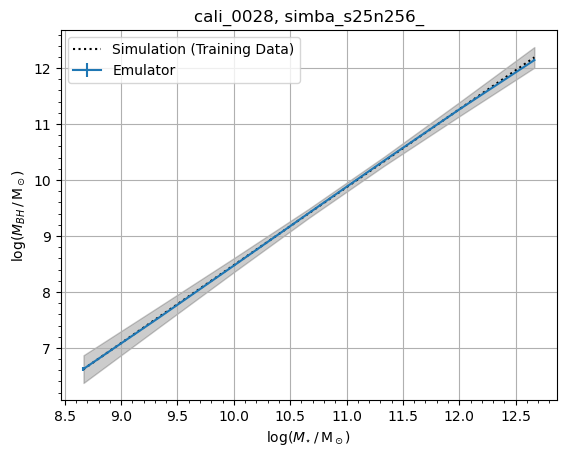

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.26912588  7.29223006  8.34177233  9.40407675 10.46446076 11.50757354
 12.51775559]
yerr:  [0.0488932  0.02257772 0.01094902 0.00666671 0.00692714 0.01310167
 0.03101043]
Slope:  [1.5346562746782242, 1.5743134088321624, 1.5934566335501912, 1.5905760052721134, 1.564669170394297, 1.5152730842154205]


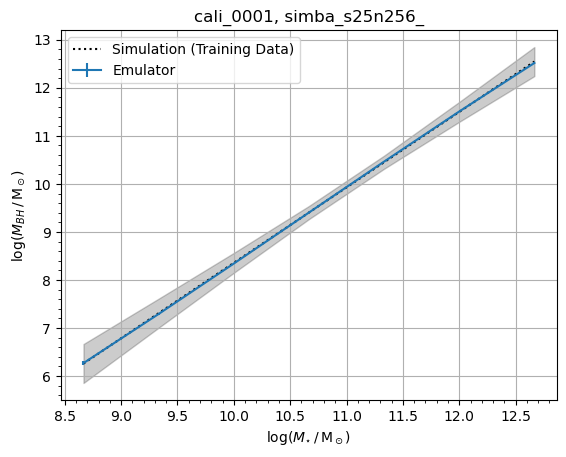

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.53717874  7.3191524   8.12014043  8.93133304  9.74303498 10.54484674
 11.325871  ]
yerr:  [0.00608154 0.00206348 0.00086472 0.00053125 0.00051711 0.00105687
 0.00356502]
Slope:  [1.1729604838304775, 1.2014820450242152, 1.2167889243441306, 1.217552901883207, 1.2027176402250332, 1.1715363989065548]


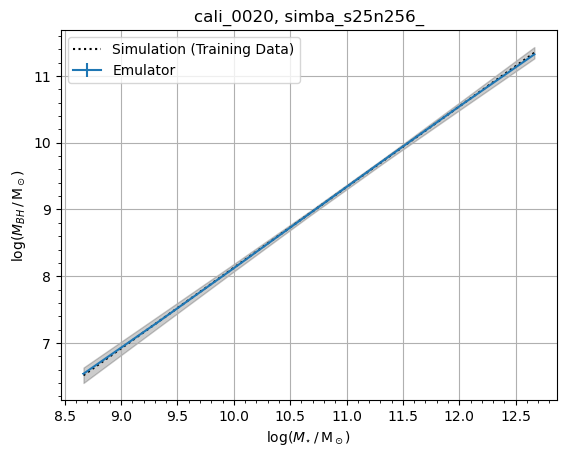

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 5.91229986  6.83909214  7.78887537  8.7496755   9.70861393 10.65219318
 11.56660243]
yerr:  [0.03314276 0.01318289 0.0059572  0.00380976 0.00378481 0.0072852
 0.02033257]
Slope:  [1.3901884257677157, 1.4246748448522921, 1.4412001887891122, 1.438407645807915, 1.4153688774662367, 1.3716138670594067]


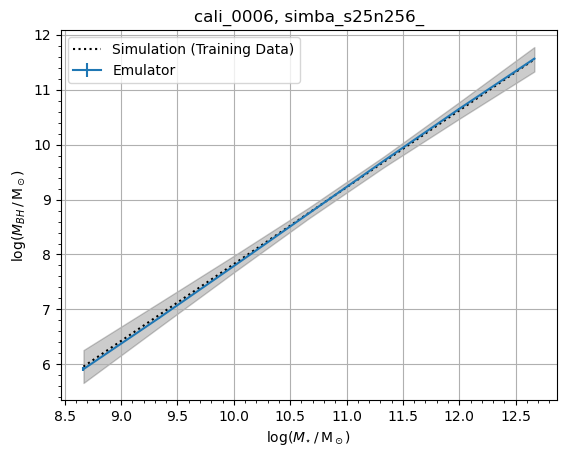

x:  [ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]
y:  [ 6.24370425  7.16055619  8.0986444   9.04617836  9.99048709 10.91829923
 11.816043  ]
yerr:  [0.03265656 0.01242572 0.00549149 0.00359363 0.00351357 0.00677485
 0.0198839 ]
Slope:  [1.3752779102309394, 1.407132305372636, 1.4213009493246829, 1.4164630846067836, 1.3917182190440063, 1.3466156435412924]


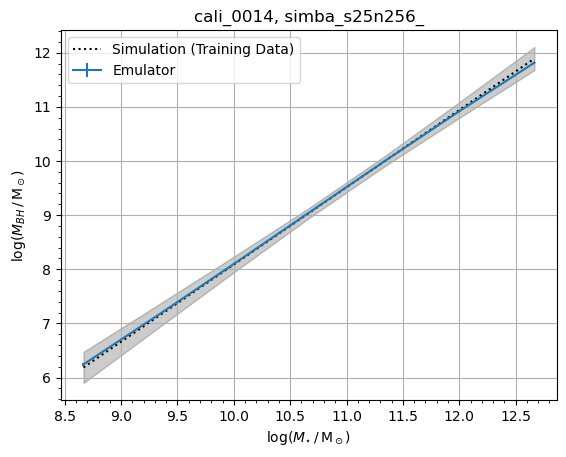

In [482]:
# Make predictions with trained emulator to compare to input

for cali in emulator.model_parameters.model_parameters:
    pred_params = emulator.model_parameters[cali]
    pred_x = emulator.model_values[cali]['independent']
    sim_y = emulator.model_values[cali]['dependent']
    sim_yerr = emulator.model_values[cali]['dependent_error']

    pred_y, pred_var = emulator.predict_values(pred_x, pred_params)
    
    print("x: ", pred_x)
    print("y: ", pred_y)
    print("yerr: ", pred_var)
    print("Slope: ", [(y2-y1)/(x2-x1) for x1, x2, y1, y2 in zip(pred_x[:-1], pred_x[1:], pred_y[:-1], pred_y[1:])])

    plt.clf()
    plt.xlabel(sim_info['X_LABEL'])
    plt.ylabel(sim_info['Y_LABEL'])
    plt.title(r'%s, %s_%s' % (cali, snap_prefix, snap_num))
    plt.grid()
    plt.minorticks_on()
#     plt.errorbar(pred_x, sim_y, yerr=sim_yerr, color="black", ls=":", label="Simulation (Training Data)")
    plt.plot(pred_x, sim_y, color="black", ls=":", label="Simulation (Training Data)")
    plt.fill_between(pred_x, sim_y-sim_yerr, sim_y+sim_yerr, color="black", alpha=0.2)
    plt.errorbar(pred_x, pred_y, yerr=pred_var, ls='-', label='Emulator')
    plt.legend()
    plt.show()

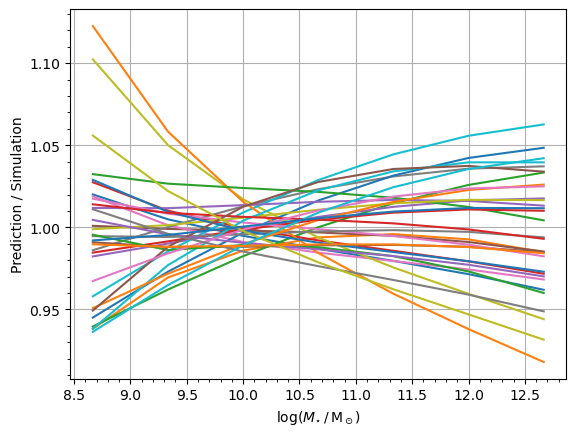

In [473]:
## See how far off each prediction is from its simulation

pred_over_sim_list = []
pred_over_sim_list_v2 = []

for cali in emulator.model_parameters.model_parameters:
    pred_params = emulator.model_parameters[cali]
    pred_x = emulator.model_values[cali]['independent']
    sim_y = emulator.model_values[cali]['dependent']

    pred_y, pred_var = emulator.predict_values(pred_x, pred_params)
    
    pred_over_sim = pred_y/sim_y
    pred_over_sim_list = np.append(pred_over_sim_list, pred_over_sim)
    pred_over_sim_list_v2.append([pred_x, pred_over_sim])

    plt.plot(pred_x, pred_over_sim)

plt.grid()
plt.minorticks_on()
plt.xlabel(sim_info['X_LABEL'])
plt.ylabel("Prediction / Simulation")
plt.show()

## Parameter sensitivity analysis

In [474]:
# If get division by zero error, it is because there is one (or multiple) emulator(s) that
# have x values that no others have --> need to either re-bin so emulators all have same x
# values, or remove that one point from that emulator
emulator_sensitivities = basic.binwise_sensitivity(specification=emulator.model_specification,
                                                   parameters=emulator.model_parameters,
                                                   values=emulator.model_values)
list(emulator_sensitivities.values())

[array([0.18169294, 0.77719701, 0.57008071]),
 array([0.14538496, 0.79997043, 0.51786647]),
 array([0.08884519, 0.8147402 , 0.42019753]),
 array([0.00544795, 0.7551151 , 0.21177405]),
 array([ 0.01364488,  0.27423964, -0.15253338]),
 array([ 0.43047065, -0.37360201,  0.14143197]),
 array([ 0.54771967, -0.09921315,  0.58510643])]

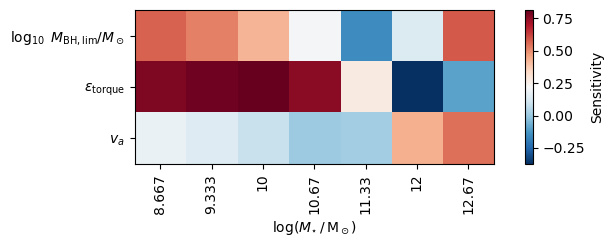

In [475]:
fig, ax = basic.plot_binwise_sensitivity(specification=emulator.model_specification,
                                         sensitivities=emulator_sensitivities,
                                         xlabel=sim_info['X_LABEL'],
                                         cbarlabel='Sensitivity',
                                         vmin=np.nanmin(list(emulator_sensitivities.values())),
                                         vmax=np.nanmax(list(emulator_sensitivities.values())))

# fig.set_size_inches(8, 8, forward=True)
fig.set_size_inches(8, 2, forward=True)

## Perform cross check (validation)

In [476]:
emulator_ccheck = cross_check.CrossCheck(hide_progress=False)
emulator_ccheck.build_emulators(model_specification=model_specification,
                        model_parameters=model_parameters,
                        model_values=model_values)

  6%|▋         | 2/32 [00:00<00:12,  2.32it/s]


ValueError: array must not contain infs or NaNs

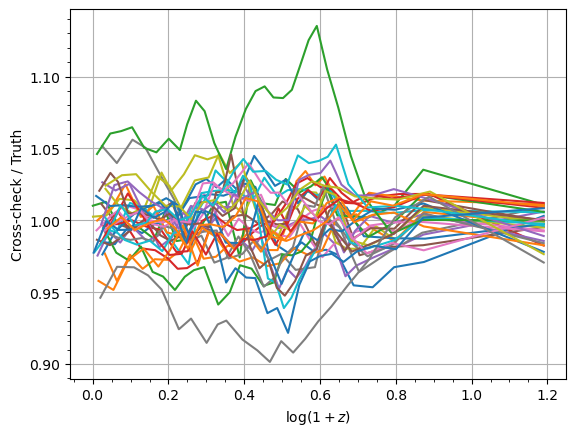

In [437]:
data_by_cc = emulator_ccheck.build_mocked_model_values_original_independent()
cc_over_og_list = []
cc_over_og_list_v2 = []

for unique_identifier in emulator_ccheck.model_values.model_values:
    cc_over_og = data_by_cc[unique_identifier]["dependent"] / \
                model_values[unique_identifier]["dependent"]
#    cc_minus_og_over_og = (data_by_cc[unique_identifier]["dependent"] / \
#                           model_values[unique_identifier]["dependent"])/ model_values[unique_identifier]["dependent"]
    cc_over_og_list = np.append(cc_over_og_list, cc_over_og)
    cc_over_og_list_v2.append([data_by_cc[unique_identifier]["independent"], cc_over_og])
    plt.plot(data_by_cc[unique_identifier]["independent"], cc_over_og)

plt.grid()
plt.minorticks_on()
plt.xlabel(sim_info['X_LABEL'])
plt.ylabel("Cross-check / Truth")
plt.show()

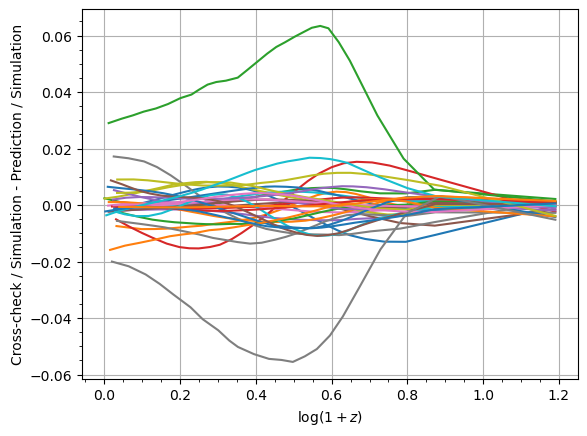

In [438]:
## One way of comparing the cross-check for each simulation to the prediction as found by
## the fully trained emulator

for pred_over_sim_, cc_over_og_ in zip(pred_over_sim_list_v2, cc_over_og_list_v2):
    plt.plot(pred_over_sim_[0], cc_over_og_[1]-pred_over_sim_[1])

plt.grid()
plt.minorticks_on()
plt.xlabel(sim_info['X_LABEL'])
plt.ylabel('Cross-check / Simulation - Prediction / Simulation')
plt.show()

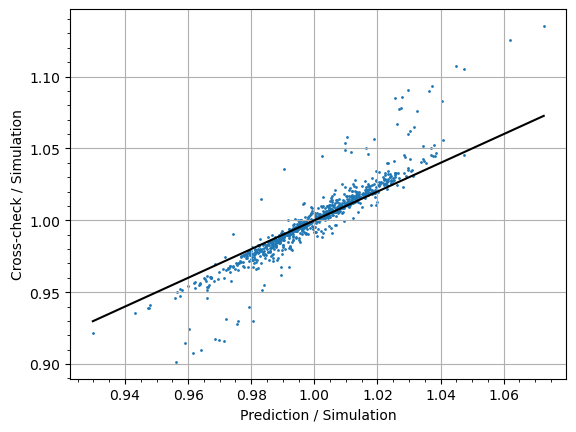

In [439]:
## Second way of comparing the cross-check for each simulation to the prediction as found by
## the fully trained emulator

plt.scatter(pred_over_sim_list, cc_over_og_list, s=1)
plt.plot([min(pred_over_sim_list), max(pred_over_sim_list)], [min(pred_over_sim_list), max(pred_over_sim_list)], color='black')

plt.grid()
plt.minorticks_on()
plt.xlabel("Prediction / Simulation")
plt.ylabel("Cross-check / Simulation")
plt.show()

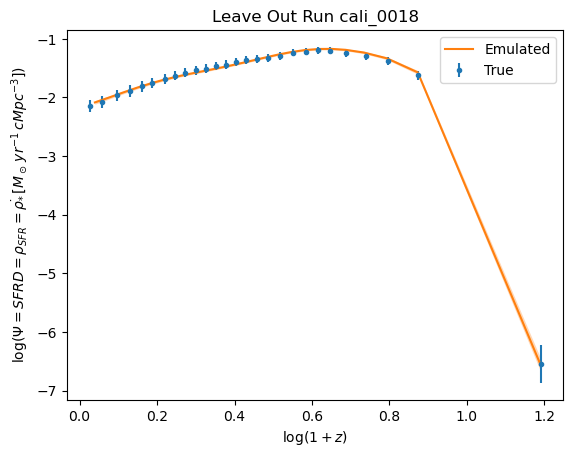

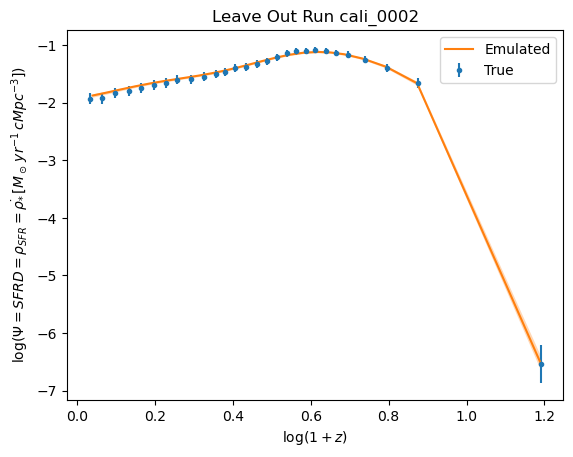

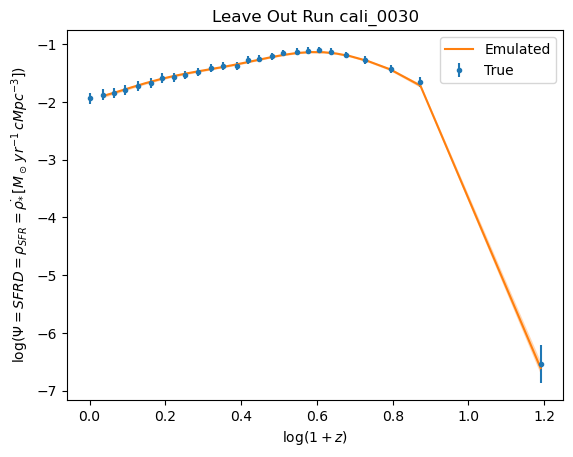

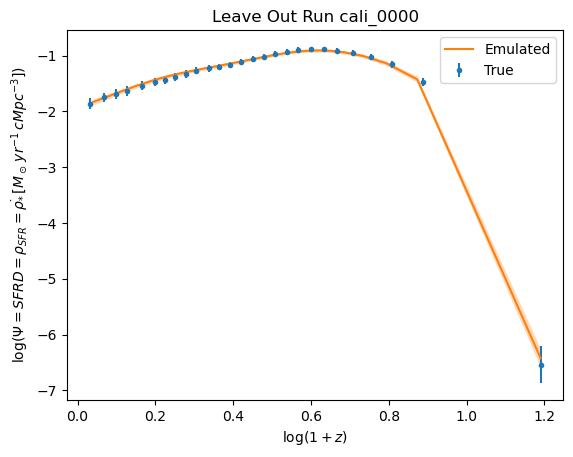

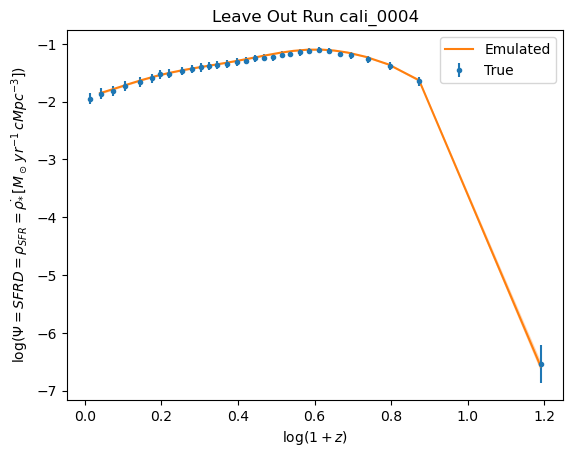

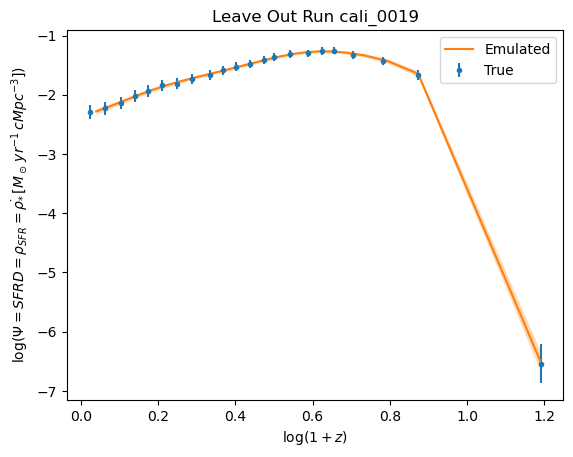

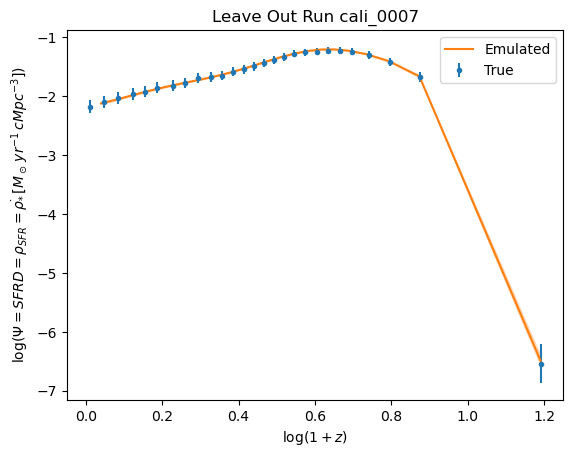

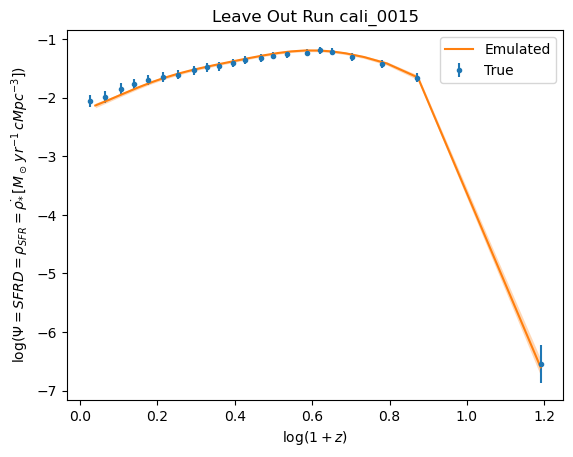

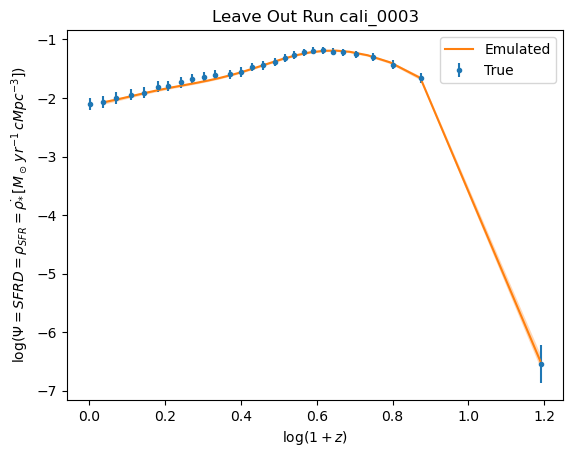

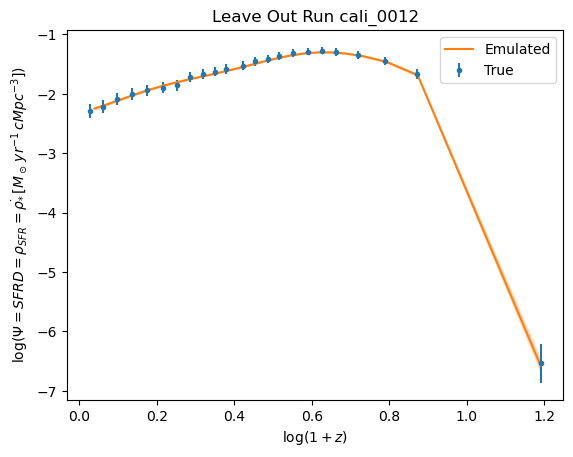

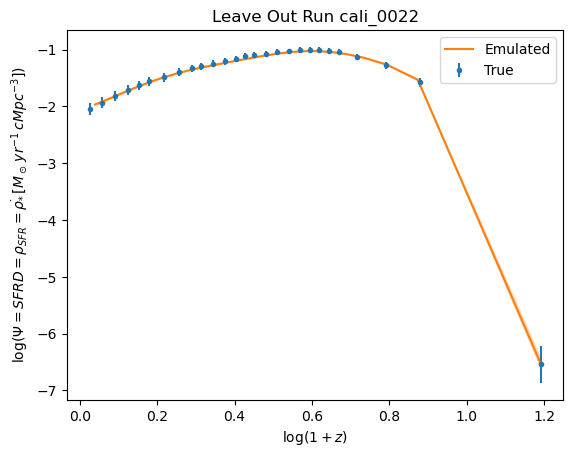

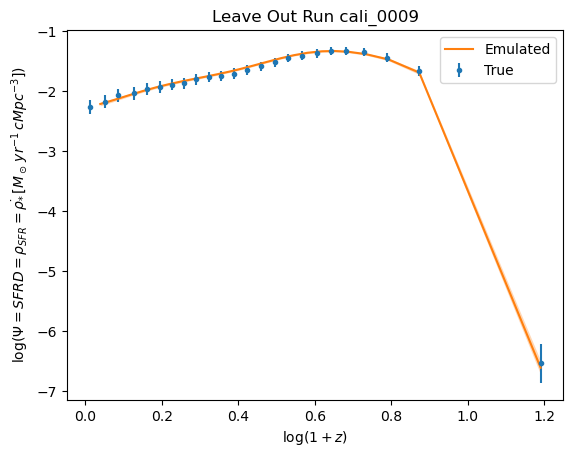

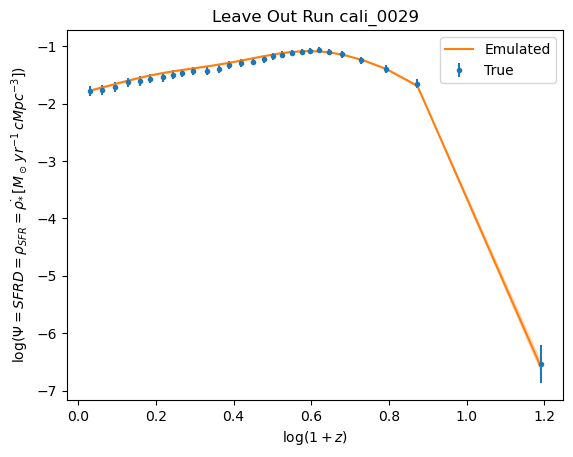

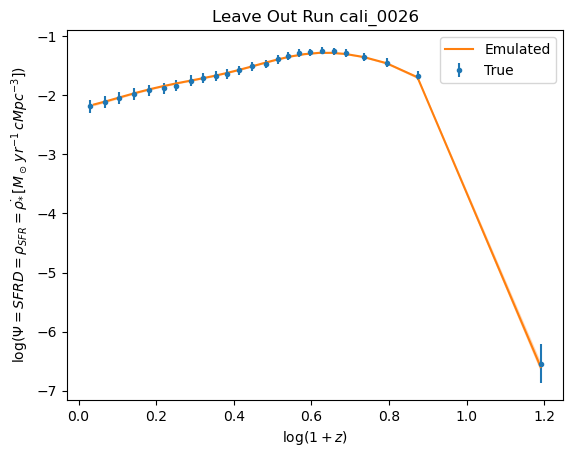

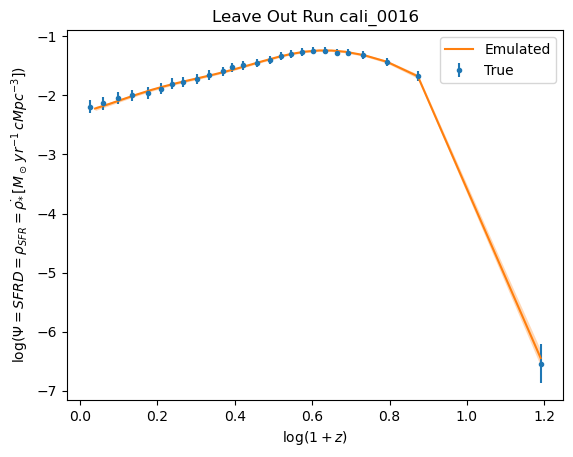

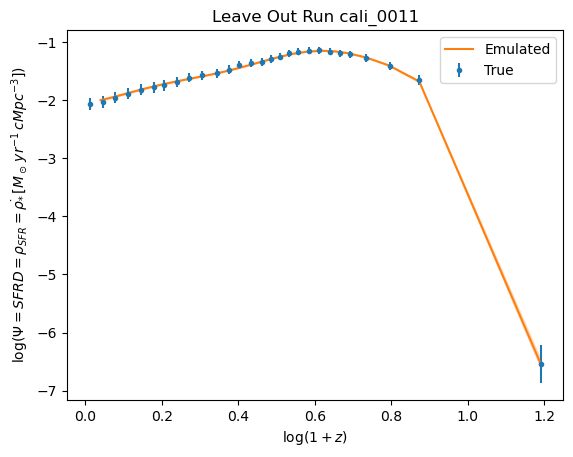

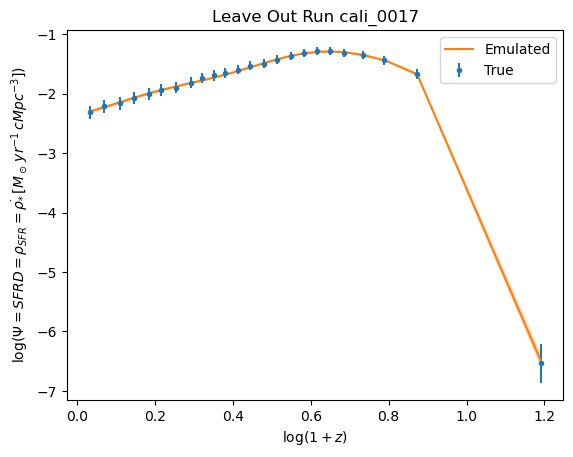

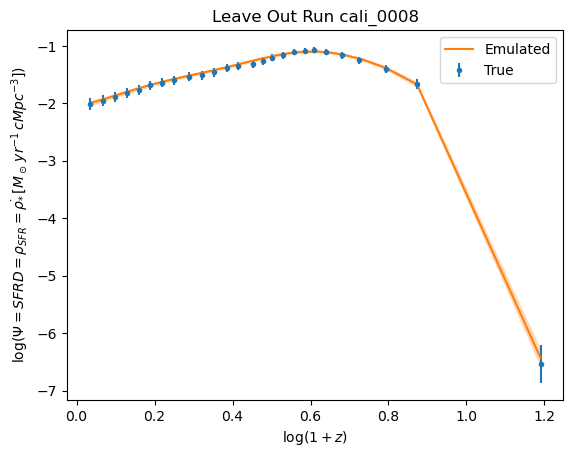

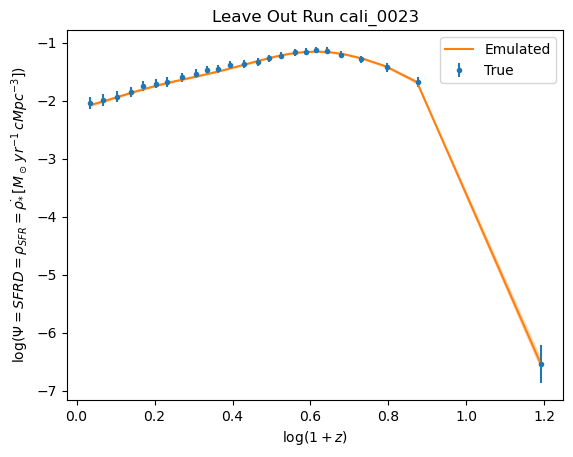

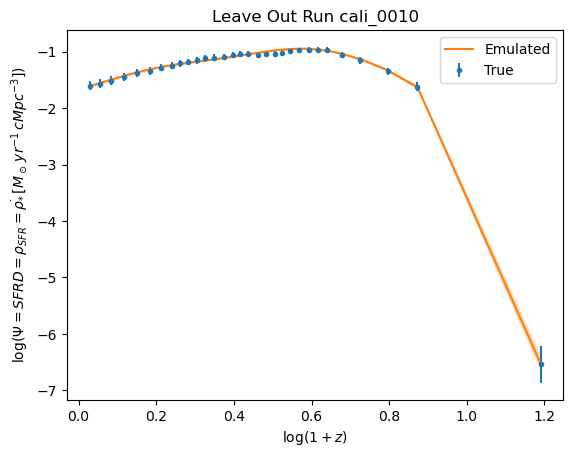

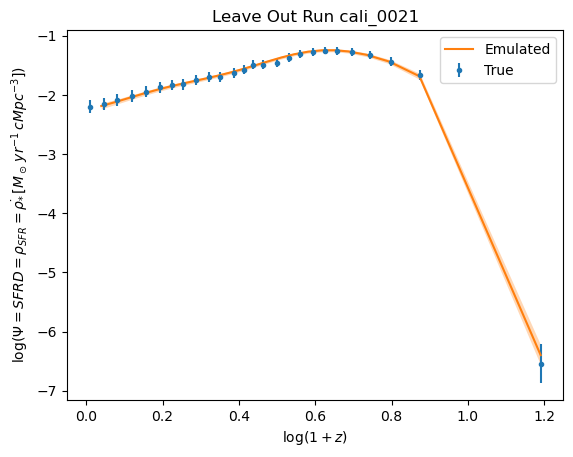

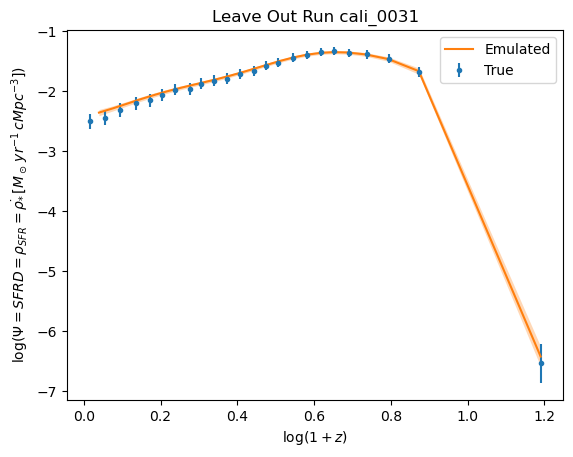

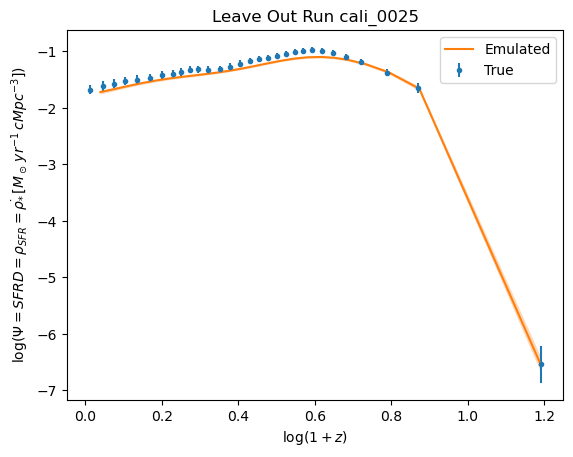

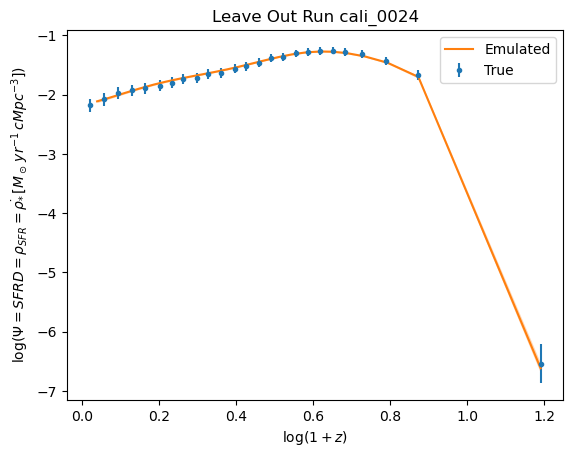

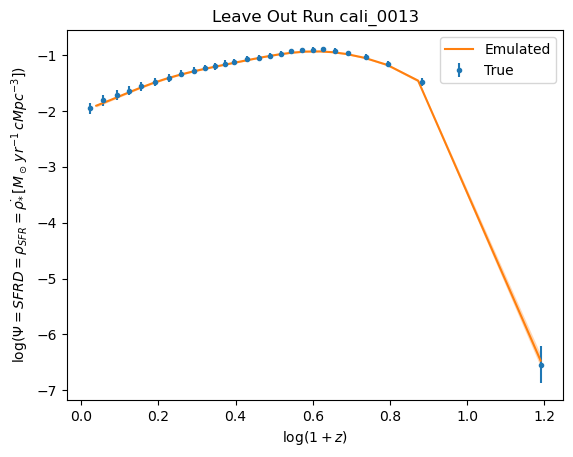

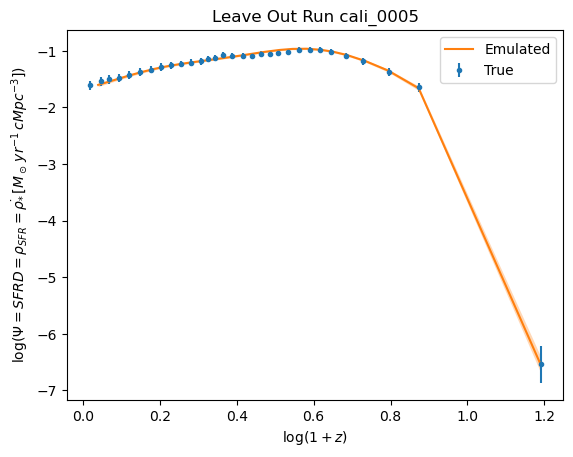

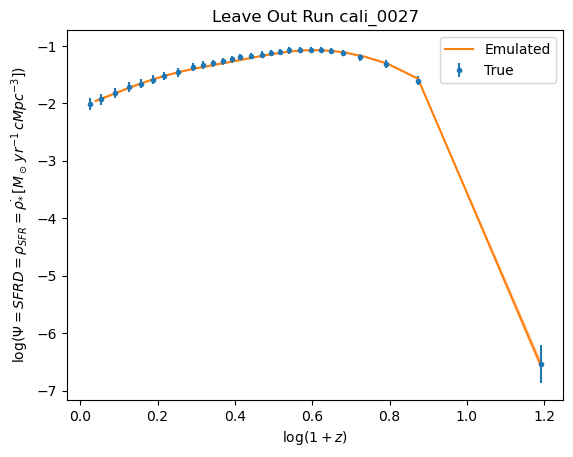

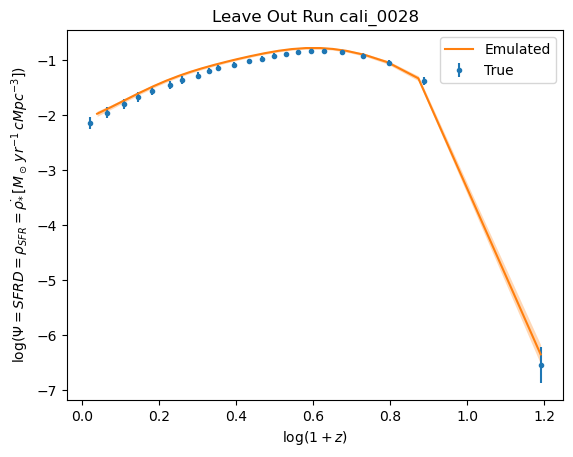

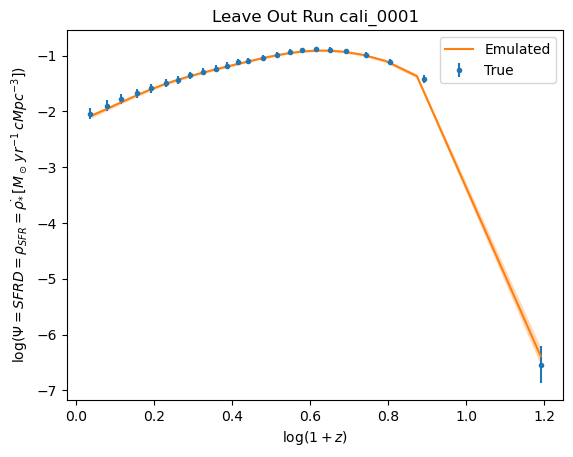

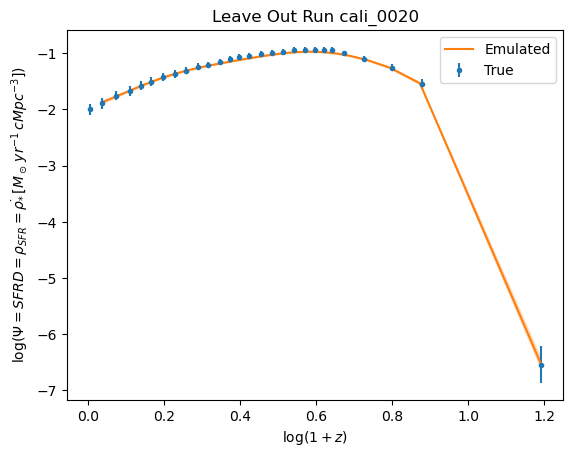

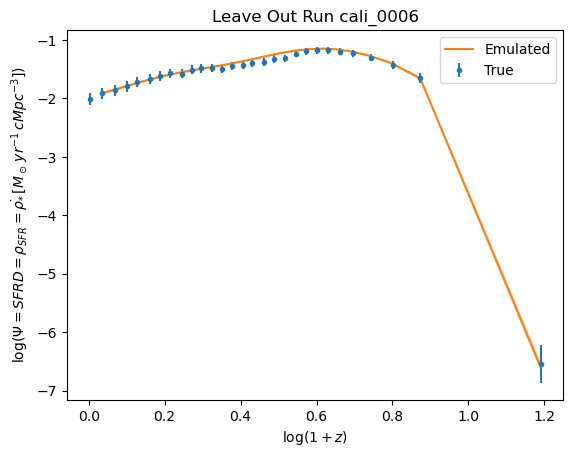

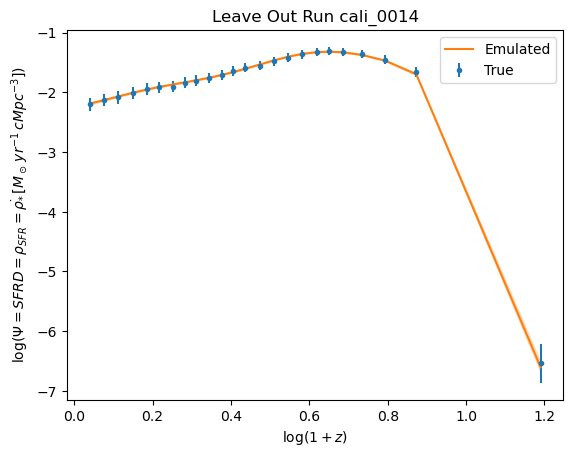

In [440]:
emulator_ccheck.plot_results(emulate_at=data_by_cc[unique_identifier]["independent"],
                         xlabel=sim_info['X_LABEL'],
                         ylabel=sim_info['Y_LABEL'])

In [441]:
total_mean_squared = emulator_ccheck.get_mean_squared()[0]
print("Total mean squared of entire set of left-out simulations: %s" % total_mean_squared)

Total mean squared of entire set of left-out simulations: 0.0013800424619410713


In [442]:
## As in FLAMINGO paper (Kugel+22), error on emulator approximated as standard deviation of
## cross-check values divided by original simulation values

sigma_ccheck = np.nanstd(cc_over_og_list)#, ddof=0)
# sigma_ccheck = total_mean_squared
print('sigma_ccheck =', sigma_ccheck)
emulator.model_specification.sigma_ccheck = sigma_ccheck

sigma_ccheck = 0.025999300708318938


In [443]:
def emulator_model(x, pred_params, emulator):
    pred_y, pred_var = emulator.predict_values(x, pred_params)
    
    pred_std = np.sqrt(pred_var)
    pred_ccheck_std = np.abs(emulator.model_specification.sigma_ccheck * pred_y)
    pred_total = np.sqrt(pred_std**2 + pred_ccheck_std**2)
    
    return pred_y, pred_ccheck_std

x:  [1.19045016 0.87410823 0.79569395 0.73892699 0.6887314  0.64709265
 0.61630169 0.58364882 0.5514622  0.51801052 0.48650615 0.45819703
 0.42949001 0.4033201  0.37822733 0.35208051 0.3267657  0.29986731
 0.27169283 0.24692862 0.21949871 0.188029   0.16178622 0.13041296
 0.09510596 0.05847108 0.02597498]
pred_y:  [-6.56182963 -1.59356044 -1.35526915 -1.25694053 -1.20376584 -1.18378458
 -1.1840812  -1.19835013 -1.22517324 -1.2637873  -1.30687253 -1.34836543
 -1.39086464 -1.42863184 -1.46338395 -1.49810487 -1.53084314 -1.5657912
 -1.60415967 -1.64074613 -1.6856895  -1.74406396 -1.79847483 -1.86944671
 -1.95418168 -2.04229995 -2.11515798]
pred_yerr:  [0.17060298 0.04143146 0.03523605 0.03267957 0.03129707 0.03077757
 0.03078528 0.03115627 0.03185365 0.03285759 0.03397777 0.03505656
 0.03616151 0.03714343 0.03804696 0.03894968 0.03980085 0.04070948
 0.04170703 0.04265825 0.04382675 0.04534444 0.04675909 0.04860431
 0.05080736 0.05309837 0.05499263]


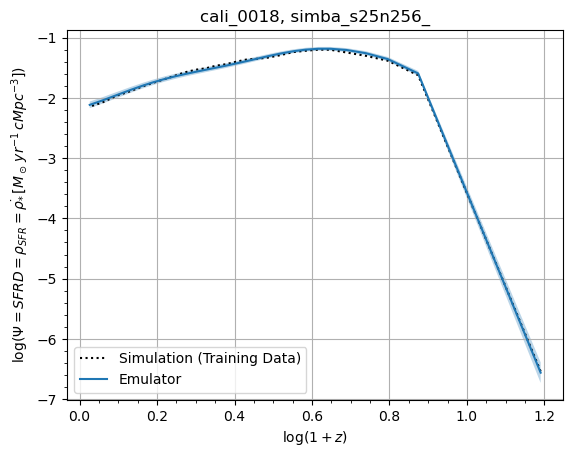

x:  [1.19045016 0.87446995 0.79628476 0.74045428 0.69564038 0.66441835
 0.63819418 0.61184843 0.58763586 0.56163876 0.5376985  0.51286799
 0.48792292 0.46223831 0.43394326 0.4061908  0.38065492 0.35600123
 0.32537304 0.29280962 0.25710721 0.22748581 0.19837085 0.16397366
 0.13179709 0.09829719 0.06398139 0.03210927]
pred_y:  [-6.52602979 -1.6694679  -1.38495883 -1.24699165 -1.16815633 -1.13255232
 -1.11650588 -1.1138029  -1.12308309 -1.14472946 -1.17395856 -1.21172797
 -1.25498118 -1.30245542 -1.3551723  -1.4046511  -1.44662311 -1.48323575
 -1.52346016 -1.56118539 -1.59957059 -1.63173157 -1.66559307 -1.70991397
 -1.75562512 -1.80588893 -1.85674319 -1.89925829]
pred_yerr:  [0.16967221 0.043405   0.03600796 0.03242091 0.03037125 0.02944557
 0.02902837 0.0289581  0.02919938 0.02976217 0.0305221  0.03150408
 0.03262863 0.03386293 0.03523353 0.03651995 0.03761119 0.03856309
 0.0396089  0.04058973 0.04158772 0.04242388 0.04330426 0.04445657
 0.04564503 0.04695185 0.04827402 0.04937939]


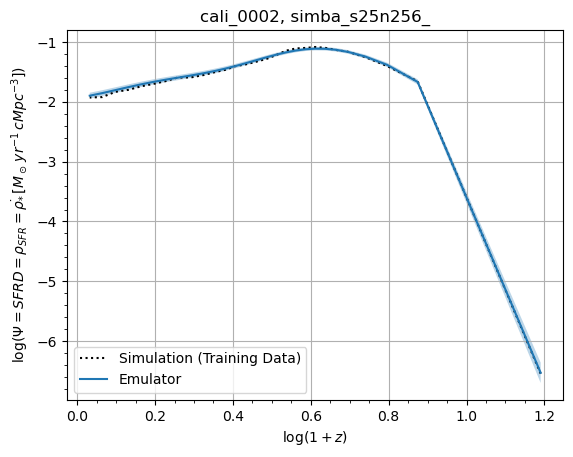

x:  [1.19045016e+00 8.72371938e-01 7.95770311e-01 7.27432125e-01
 6.77433474e-01 6.37362204e-01 6.05249931e-01 5.76054575e-01
 5.46757746e-01 5.09411485e-01 4.81136522e-01 4.47307046e-01
 4.17074751e-01 3.87967819e-01 3.51537933e-01 3.19969249e-01
 2.85064657e-01 2.50744845e-01 2.21545471e-01 1.91749245e-01
 1.62772931e-01 1.26893693e-01 9.43603921e-02 6.40396671e-02
 3.46936160e-02 3.69774575e-04]
pred_y:  [-6.59628415 -1.70690005 -1.43808393 -1.2729883  -1.18714061 -1.14466032
 -1.12997213 -1.13179549 -1.14702128 -1.1822995  -1.21729916 -1.2640324
 -1.30682146 -1.34668388 -1.39329176 -1.4310519  -1.47192587 -1.51412148
 -1.55381378 -1.59936386 -1.64901628 -1.71689942 -1.78203029 -1.8423773
 -1.89684701 -1.95079279]
pred_yerr:  [0.17149878 0.04437821 0.03738918 0.03309681 0.03086483 0.02976037
 0.02937849 0.02942589 0.02982175 0.03073896 0.03164893 0.03286396
 0.03397644 0.03501284 0.03622461 0.03720635 0.03826904 0.0393661
 0.04039807 0.04158234 0.04287327 0.04463818 0.04633154 0.047

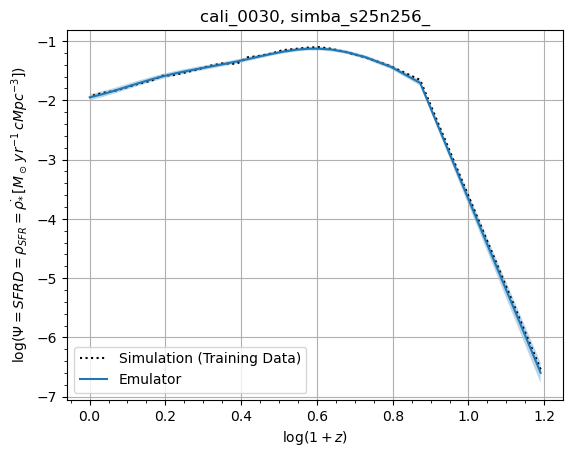

x:  [1.19045016 0.88719469 0.80898036 0.75317097 0.70684787 0.66599487
 0.6321011  0.60035155 0.56663662 0.53704337 0.50823387 0.47921486
 0.44963365 0.42041871 0.3909812  0.36273939 0.3368639  0.30503998
 0.27894293 0.24924971 0.22426344 0.19831358 0.16477849 0.12705644
 0.09900458 0.06687771 0.031004  ]
pred_y:  [-6.44056694 -1.48364216 -1.16547141 -1.02748536 -0.95026964 -0.90868979
 -0.89384785 -0.89622347 -0.91486074 -0.94290875 -0.97824357 -1.01915505
 -1.06364301 -1.10810463 -1.15196977 -1.19270971 -1.22922464 -1.2743676
 -1.31303798 -1.36065252 -1.40490097 -1.45567322 -1.5288273  -1.61985107
 -1.69122887 -1.77328162 -1.85997786]
pred_yerr:  [0.16745024 0.03857366 0.03030144 0.0267139  0.02470635 0.0236253
 0.02323942 0.02330118 0.02378574 0.02451497 0.02543365 0.02649732
 0.02765397 0.02880995 0.02995041 0.03100962 0.03195898 0.03313267
 0.03413807 0.03537601 0.03652644 0.03784649 0.03974844 0.042115
 0.04397077 0.04610408 0.04835812]


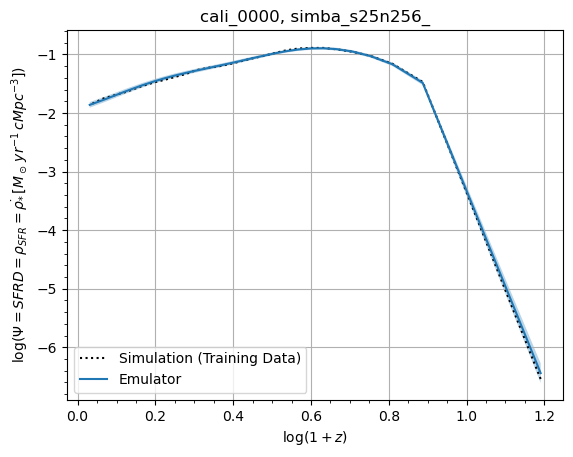

x:  [1.19045016 0.87317577 0.79597529 0.74069543 0.69605636 0.66721872
 0.63760737 0.61104158 0.58604928 0.56092134 0.53693686 0.51431087
 0.49180544 0.46686842 0.44369983 0.42076636 0.39679394 0.37207195
 0.34442397 0.32393618 0.30262447 0.27919663 0.25259366 0.2206954
 0.19706863 0.17490282 0.14308697 0.10378991 0.07265881 0.04290278
 0.01280514]
pred_y:  [-6.57772716 -1.63312426 -1.36704068 -1.24124417 -1.16724212 -1.13329781
 -1.11100706 -1.10240698 -1.10409429 -1.11470935 -1.13212053 -1.15381455
 -1.17912445 -1.20987177 -1.23952631 -1.26875212 -1.29831214 -1.32727659
 -1.35791301 -1.37985086 -1.40260872 -1.42842495 -1.46003852 -1.50303786
 -1.53941929 -1.57735913 -1.63791729 -1.72012866 -1.78742082 -1.84965424
 -1.90666805]
pred_yerr:  [0.17101631 0.04246009 0.0355421  0.03227148 0.03034748 0.02946495
 0.02888541 0.02866181 0.02870568 0.02898166 0.02943434 0.02999837
 0.03065641 0.03145582 0.03222682 0.03298667 0.03375521 0.03450826
 0.03530479 0.03587516 0.03646685 0.03713805 0.0

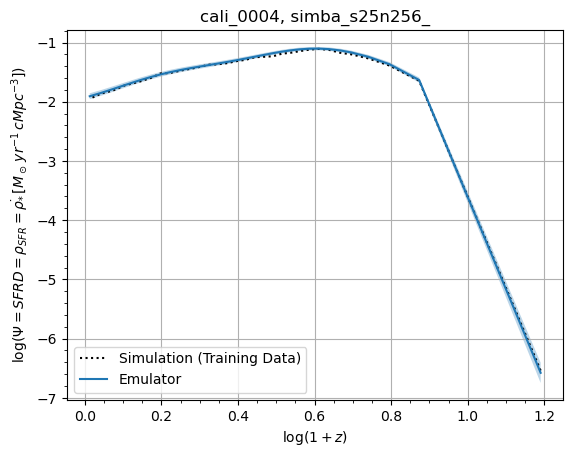

x:  [1.19045016 0.87206648 0.78125704 0.70447455 0.65397349 0.62423756
 0.58893908 0.54104648 0.50099129 0.47276255 0.43879442 0.40240472
 0.36783171 0.33283064 0.28725913 0.249732   0.20933115 0.17311027
 0.14001228 0.10236962 0.06301982 0.02263454]
pred_y:  [-6.52029411 -1.65327952 -1.4158588  -1.30853735 -1.27309692 -1.26788255
 -1.27808923 -1.31905722 -1.3724941  -1.41693141 -1.47399967 -1.53583656
 -1.59308898 -1.64937286 -1.722962   -1.78790041 -1.86641815 -1.94624284
 -2.02645767 -2.12294768 -2.22338655 -2.31669756]
pred_yerr:  [0.16952309 0.04298411 0.03681134 0.03402106 0.03309963 0.03296406
 0.03322943 0.03429457 0.03568389 0.03683923 0.03832296 0.03993068
 0.0414192  0.04288254 0.04479581 0.04648416 0.04852557 0.05060095
 0.05268648 0.05519516 0.0578065  0.06023252]


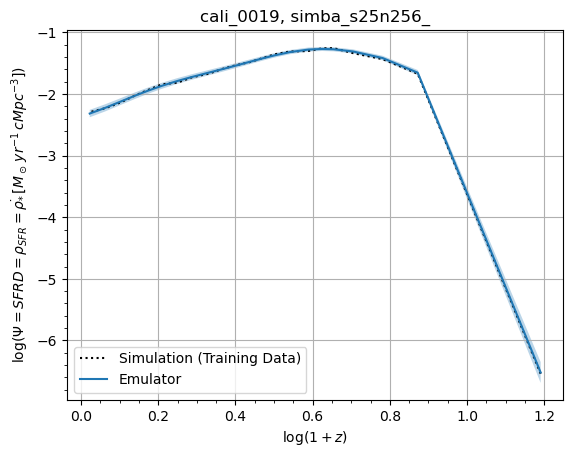

x:  [1.19045016 0.87501656 0.79667463 0.74183889 0.69609052 0.664134
 0.63405844 0.60614922 0.57482371 0.54599811 0.51958907 0.49306948
 0.46653482 0.4402775  0.4137127  0.38531717 0.35766318 0.32682396
 0.29317938 0.25900427 0.22763454 0.18712116 0.15482701 0.12282628
 0.0853725  0.04839099 0.01013639]
pred_y:  [-6.49837729 -1.67755894 -1.41990996 -1.30625553 -1.24363106 -1.21917147
 -1.21240098 -1.22086451 -1.2468069  -1.28437216 -1.32802239 -1.37808783
 -1.43161921 -1.48531449 -1.53808046 -1.59089016 -1.63780274 -1.68491473
 -1.73154013 -1.77661819 -1.81878802 -1.87782495 -1.92981793 -1.98500656
 -2.05113213 -2.1125775  -2.16473073]
pred_yerr:  [0.16895327 0.04361536 0.03691667 0.03396173 0.03233354 0.03169761
 0.03152158 0.03174162 0.03241611 0.03339278 0.03452765 0.03582932
 0.0372211  0.03861714 0.03998902 0.04136203 0.04258173 0.0438066
 0.04501883 0.04619083 0.04728722 0.04882214 0.05017392 0.05160878
 0.053328   0.05492554 0.05628149]


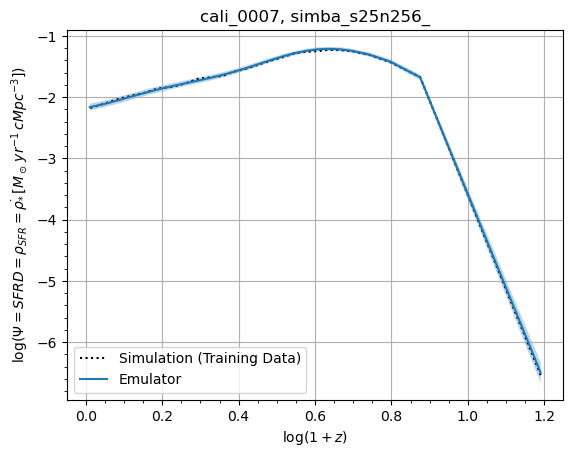

x:  [1.19045016 0.86971928 0.78165092 0.70313214 0.65188754 0.61940047
 0.58655972 0.53562863 0.4981035  0.46704124 0.42722318 0.39524655
 0.35838261 0.32732235 0.29346876 0.25272076 0.21496204 0.175566
 0.13904769 0.10497306 0.06377944 0.02493098]
pred_y:  [-6.59169706 -1.6527201  -1.40552289 -1.27630684 -1.22549349 -1.20971126
 -1.20785094 -1.23150232 -1.26545487 -1.30042077 -1.34979709 -1.39059139
 -1.43768031 -1.47799792 -1.52451316 -1.58779764 -1.65716111 -1.74261663
 -1.83301511 -1.92406909 -2.0360471  -2.13481605]
pred_yerr:  [0.17137951 0.04296957 0.03654261 0.03318309 0.03186197 0.03145165
 0.03140328 0.0320182  0.03290094 0.03381003 0.03509378 0.0361544
 0.03737868 0.03842691 0.03963628 0.04128163 0.04308503 0.04530681
 0.04765711 0.05002445 0.0529358  0.05550372]


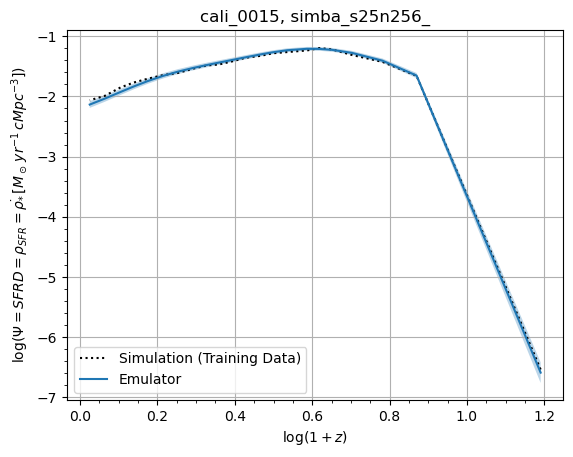

x:  [1.19045016e+00 8.73802767e-01 8.00307969e-01 7.47696849e-01
 7.03473769e-01 6.69780946e-01 6.41383405e-01 6.14983392e-01
 5.90008177e-01 5.65093261e-01 5.39903019e-01 5.15166958e-01
 4.89199009e-01 4.58400002e-01 4.28236015e-01 3.98785451e-01
 3.70600920e-01 3.31593734e-01 3.02751077e-01 2.69565663e-01
 2.40857638e-01 2.07184924e-01 1.81709307e-01 1.44698656e-01
 1.09410229e-01 7.06411721e-02 3.60601082e-02 7.68672024e-04]
pred_y:  [-6.50991073 -1.66413753 -1.41452137 -1.29806599 -1.23113573 -1.2009751
 -1.19127784 -1.19589079 -1.21225251 -1.23941003 -1.27640665 -1.32010089
 -1.37130384 -1.43533437 -1.49757237 -1.55476274 -1.60443283 -1.66417437
 -1.70256576 -1.74300288 -1.77706357 -1.81862465 -1.85248913 -1.9060924
 -1.96083266 -2.02094881 -2.06923804 -2.1073947 ]
pred_yerr:  [0.16925313 0.04326641 0.03677657 0.03374881 0.03200867 0.03122451
 0.03097239 0.03109232 0.03151772 0.03222379 0.03318568 0.0343217
 0.03565294 0.03731769 0.03893583 0.04042274 0.04171413 0.04326737
 0.0442

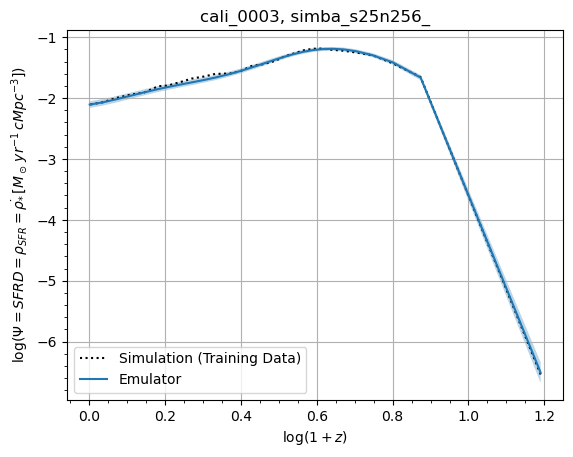

x:  [1.19045016 0.87211471 0.7884996  0.71940983 0.66184607 0.62740669
 0.59084618 0.5529071  0.51462034 0.48780837 0.45294195 0.42281817
 0.37939491 0.34965696 0.31895742 0.28649749 0.25322064 0.21719872
 0.17502744 0.13631766 0.09850418 0.06232148 0.02726364]
pred_y:  [-6.57020457 -1.67809182 -1.45198161 -1.34783094 -1.30196133 -1.29538863
 -1.30724462 -1.33923762 -1.38826643 -1.4295774  -1.4877669  -1.5389619
 -1.61005181 -1.65586334 -1.70129883 -1.74906394 -1.80033157 -1.86146954
 -1.94322248 -2.02777269 -2.11576224 -2.19940172 -2.27345938]
pred_yerr:  [0.17082072 0.04362921 0.03775051 0.03504266 0.03385008 0.0336792
 0.03398745 0.03481924 0.03609396 0.03716801 0.0386809  0.04001193
 0.04186022 0.04305129 0.04423258 0.04547444 0.04680736 0.04839691
 0.05052243 0.05272067 0.05500834 0.05718291 0.05910835]


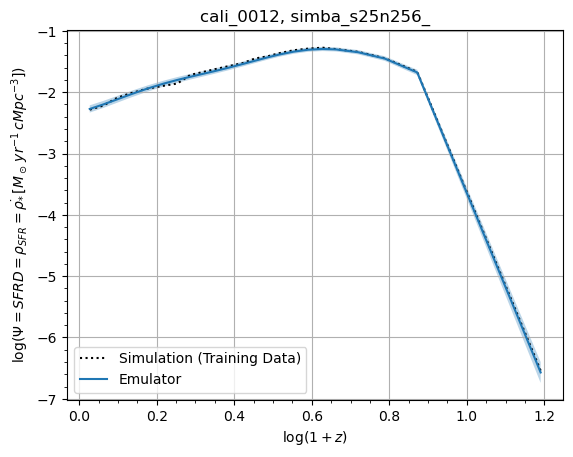

x:  [1.19045016 0.87751649 0.79044489 0.71586089 0.67024315 0.64318299
 0.61789328 0.59391884 0.56861406 0.54166744 0.50956672 0.48122997
 0.44987632 0.42618221 0.40281067 0.3750371  0.34521575 0.31268448
 0.28910996 0.25536288 0.2167988  0.17975398 0.15189302 0.12340906
 0.09220009 0.05735575 0.0256424 ]
pred_y:  [-6.52611592 -1.55497334 -1.2610903  -1.11511241 -1.05783423 -1.03607367
 -1.02454893 -1.02159868 -1.0266212  -1.0403391  -1.06607649 -1.09515322
 -1.13178911 -1.16125594 -1.19110567 -1.22723674 -1.26708972 -1.31306175
 -1.34917311 -1.40695665 -1.48436409 -1.57161892 -1.64511165 -1.72568517
 -1.81746103 -1.91935147 -2.00630448]
pred_yerr:  [0.16967445 0.04042822 0.03278747 0.02899214 0.02750295 0.02693719
 0.02663756 0.02656085 0.02669143 0.02704809 0.02771724 0.02847322
 0.02942573 0.03019184 0.03096791 0.0319073  0.03294345 0.03413869
 0.03507756 0.03657989 0.03859243 0.04086099 0.04277175 0.04486661
 0.04725272 0.0499018  0.05216251]


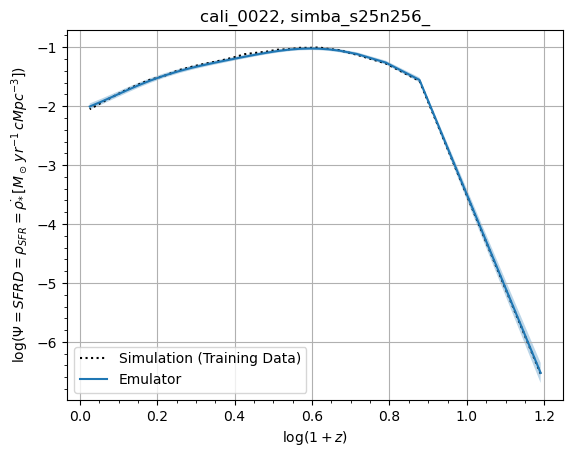

x:  [1.19045016 0.87333654 0.78882114 0.72915234 0.68265841 0.64277203
 0.60550515 0.56685768 0.53125575 0.49560157 0.46032519 0.42206256
 0.38764125 0.35541242 0.32442451 0.28883765 0.25789497 0.22610724
 0.19573727 0.16040163 0.12724336 0.08642703 0.05135715 0.01180436]
pred_y:  [-6.60559439 -1.68897779 -1.46342043 -1.37944972 -1.34395405 -1.33617273
 -1.34952466 -1.38388505 -1.43107091 -1.488483   -1.54981956 -1.61553415
 -1.67021917 -1.71633092 -1.75653669 -1.79993712 -1.83795378 -1.8799883
 -1.9248634  -1.98397654 -2.0455573  -2.12574727 -2.19313321 -2.25967843]
pred_yerr:  [0.17174083 0.04391224 0.03804791 0.03586473 0.03494187 0.03473956
 0.0350867  0.03598004 0.03720684 0.03869952 0.04029422 0.04200276
 0.04342453 0.0446234  0.04566873 0.04679711 0.04778551 0.04887838
 0.0500451  0.051582   0.05318306 0.05526794 0.05701993 0.05875006]


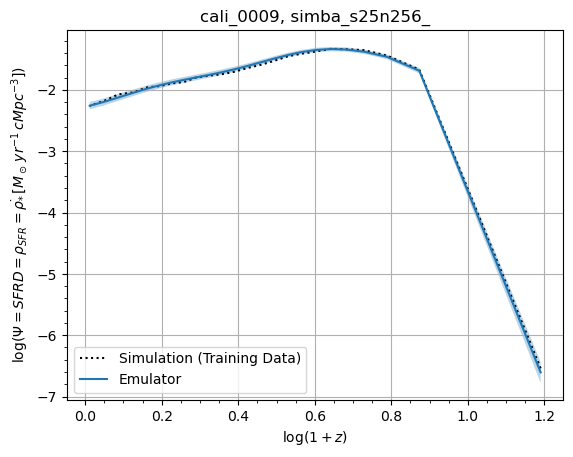

x:  [1.19045016 0.87116618 0.79326636 0.72799079 0.67880803 0.64596728
 0.6186308  0.59537982 0.57498045 0.55069454 0.5255063  0.50035626
 0.47849189 0.450647   0.41942195 0.38890027 0.36162206 0.33132947
 0.29449768 0.26703057 0.24305413 0.21710829 0.18577072 0.15824733
 0.12719563 0.09560433 0.06224408 0.02945659]
pred_y:  [-6.57190767 -1.6793264  -1.39711263 -1.233339   -1.14576194 -1.10781161
 -1.09031048 -1.08575283 -1.08930836 -1.10195942 -1.12332369 -1.1510816
 -1.17872669 -1.2162929  -1.25856067 -1.29752468 -1.32931728 -1.36130648
 -1.3972098  -1.42384858 -1.44849569 -1.47787459 -1.51837757 -1.55892102
 -1.60964579 -1.66474161 -1.72321665 -1.77651549]
pred_yerr:  [0.170865   0.04366131 0.03632395 0.03206595 0.02978901 0.02880233
 0.02834731 0.02822881 0.02832126 0.02865017 0.02920563 0.02992732
 0.03064607 0.03162276 0.0327217  0.03373473 0.03456132 0.03539302
 0.03632648 0.03701907 0.03765987 0.03842371 0.03947675 0.04053086
 0.04184967 0.04328212 0.04480243 0.04618816]


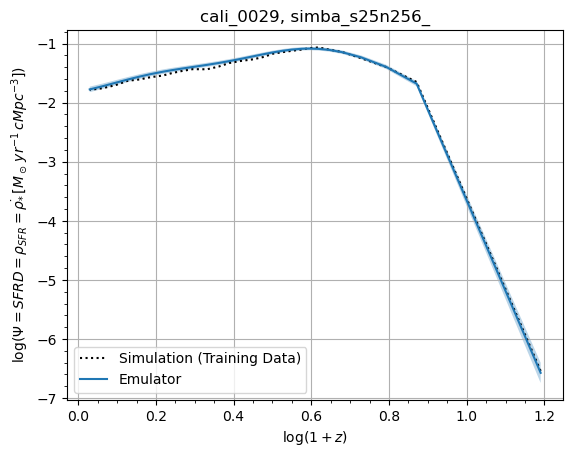

x:  [1.19045016 0.87322401 0.79531815 0.73546245 0.69014012 0.656803
 0.62592361 0.59727386 0.56838899 0.54073298 0.51419632 0.48240658
 0.44731509 0.41438893 0.38121056 0.35272761 0.32078716 0.28848044
 0.25076693 0.22122394 0.18052367 0.14164408 0.10310614 0.06763281
 0.02867286]
pred_y:  [-6.59206087 -1.69480714 -1.46133086 -1.35380468 -1.30246516 -1.28307049
 -1.28068875 -1.29239601 -1.31719681 -1.35166898 -1.39251886 -1.44802637
 -1.51264914 -1.57201599 -1.6275381  -1.67080807 -1.71492949 -1.7565577
 -1.80482911 -1.84504265 -1.90689054 -1.97378288 -2.04534252 -2.11132667
 -2.17696076]
pred_yerr:  [0.17138897 0.0440638  0.03799358 0.03519797 0.03386318 0.03335894
 0.03329701 0.03360139 0.0342462  0.03514245 0.03620452 0.03764767
 0.03932782 0.04087132 0.04231485 0.04343984 0.04458697 0.04566927
 0.04692429 0.04796982 0.04957782 0.05131697 0.05317748 0.05489302
 0.05659946]


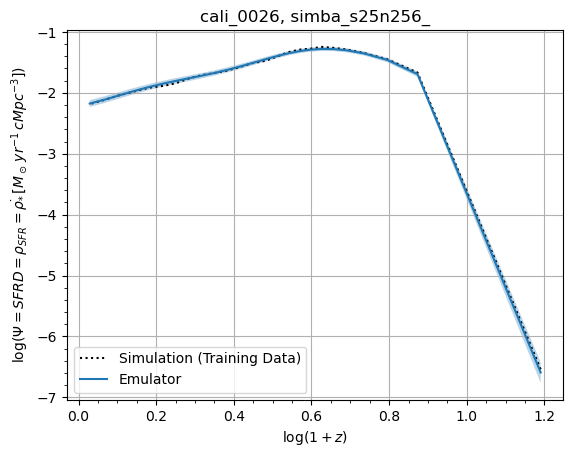

x:  [1.19045016 0.87404392 0.79234195 0.73102528 0.69234062 0.66311111
 0.63393585 0.60266258 0.57346522 0.54527466 0.5198694  0.49040476
 0.45736305 0.42260515 0.39411716 0.36982925 0.33246288 0.30199748
 0.26557161 0.23827732 0.20949193 0.17589155 0.13579619 0.09721402
 0.06036009 0.02546554]
pred_y:  [-6.4583094  -1.68132973 -1.43052559 -1.31700747 -1.26997013 -1.24841879
 -1.24028729 -1.24720017 -1.26797264 -1.29984261 -1.33674816 -1.38657193
 -1.44745453 -1.51259931 -1.5641878  -1.60593747 -1.66602713 -1.71248167
 -1.76786174 -1.81136057 -1.86075998 -1.92416938 -2.00757637 -2.09233008
 -2.17142634 -2.23793587]
pred_yerr:  [0.16791153 0.0437134  0.03719266 0.03424127 0.03301834 0.03245802
 0.0322466  0.03242633 0.0329664  0.033795   0.03475452 0.0360499
 0.03763281 0.03932652 0.04066779 0.04175325 0.04331554 0.04452333
 0.04596317 0.04709411 0.04837846 0.05002706 0.05219558 0.05439912
 0.05645557 0.05818477]


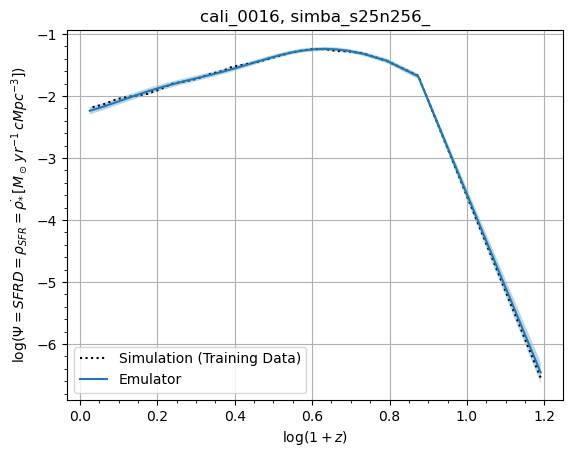

x:  [1.19045016 0.87344908 0.79616821 0.7338588  0.69276465 0.66522319
 0.63876088 0.61090995 0.58356944 0.55663287 0.5319159  0.50924871
 0.48607208 0.46066079 0.43316154 0.40240472 0.37545609 0.34277611
 0.30487521 0.27091311 0.23895857 0.20566568 0.1797781  0.14414403
 0.1107888  0.07834997 0.04565792 0.01115727]
pred_y:  [-6.53500378 -1.68095688 -1.41225282 -1.26848007 -1.20202574 -1.17204995
 -1.15568098 -1.15240929 -1.16310493 -1.18618209 -1.21678816 -1.25114253
 -1.29069171 -1.33700591 -1.38802649 -1.44334622 -1.48862541 -1.53869733
 -1.59103271 -1.63520341 -1.67725277 -1.72416755 -1.76393392 -1.82362448
 -1.88325421 -1.94170903 -1.99691078 -2.04584495]
pred_yerr:  [0.16990553 0.0437037  0.03671759 0.03297959 0.03125183 0.03047248
 0.0300469  0.02996184 0.03023991 0.0308399  0.03163564 0.03252883
 0.03355708 0.03476122 0.03608772 0.03752599 0.03870322 0.04000505
 0.04136574 0.04251415 0.0436074  0.04482715 0.04586105 0.04741296
 0.04896329 0.05048308 0.05191828 0.05319054]


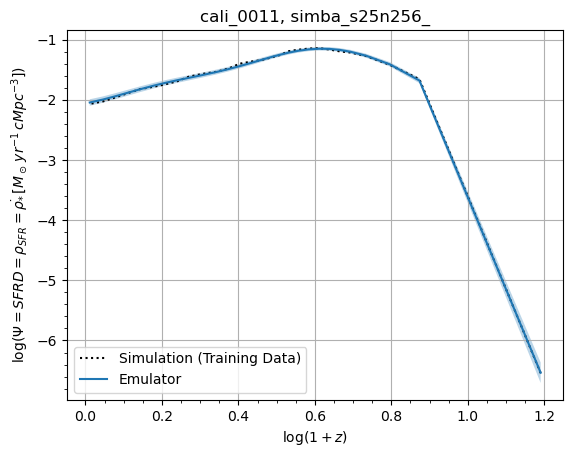

x:  [1.19045016 0.87217902 0.78915473 0.73300271 0.68625156 0.64830243
 0.61467392 0.58205421 0.5481524  0.51433499 0.47899028 0.44416807
 0.41373481 0.38038764 0.3516143  0.32017824 0.29147122 0.25310509
 0.21477716 0.1833803  0.14488355 0.11004927 0.0688406  0.03214945]
pred_y:  [-6.4949769  -1.66988549 -1.43657406 -1.34626422 -1.30178102 -1.28854703
 -1.29588296 -1.32035558 -1.36229609 -1.41746407 -1.484225   -1.55353992
 -1.61317502 -1.67480246 -1.72400334 -1.77400505 -1.81759815 -1.87595996
 -1.93831251 -1.99452159 -2.07020502 -2.1431479  -2.22917373 -2.29827836]
pred_yerr:  [0.16886486 0.04341586 0.03734992 0.03500193 0.0338454  0.03350132
 0.03369205 0.03432832 0.03541875 0.03685307 0.03858881 0.04039095
 0.04194142 0.04354369 0.04482288 0.04612289 0.04725628 0.04877365
 0.05039477 0.05185617 0.05382388 0.05572035 0.05795696 0.05975363]


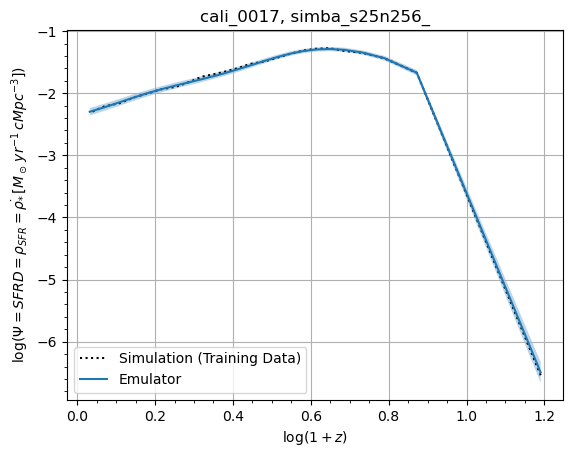

x:  [1.19045016 0.87384296 0.79332262 0.7254587  0.67965608 0.63950845
 0.60865318 0.58556799 0.55865854 0.52849055 0.50197801 0.47895109
 0.45178443 0.4150973  0.38468816 0.35221718 0.32114487 0.28699386
 0.24992091 0.21773529 0.18764716 0.15960482 0.13015023 0.09954111
 0.06722486 0.03352202]
pred_y:  [-6.45405916 -1.67921554 -1.39047906 -1.22728886 -1.15167217 -1.11315249
 -1.10336266 -1.10749439 -1.12398503 -1.1555132  -1.19217483 -1.22875751
 -1.27516621 -1.33924916 -1.39069127 -1.44243673 -1.48903344 -1.53860763
 -1.59364005 -1.64519917 -1.69814985 -1.7519715  -1.81241002 -1.87746018
 -1.94508757 -2.00943632]
pred_yerr:  [0.16780102 0.04365843 0.03615148 0.03190865 0.02994267 0.02894119
 0.02868666 0.02879408 0.02922282 0.03004254 0.03099571 0.03194684
 0.03315343 0.03481954 0.036157   0.03750235 0.03871383 0.04000272
 0.04143353 0.04277403 0.04415071 0.04555003 0.04712139 0.04881265
 0.05057092 0.05224394]


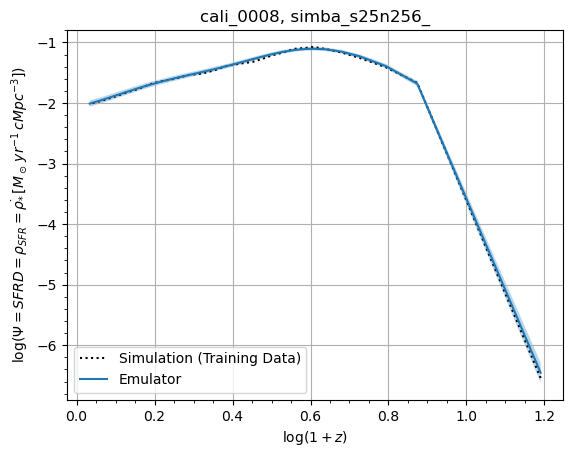

x:  [1.19045016 0.8746066  0.79539652 0.72846104 0.67895674 0.64181747
 0.61380175 0.58865473 0.56030641 0.52480898 0.49346336 0.46620928
 0.42834857 0.39242509 0.36187728 0.33360935 0.3061292  0.26950237
 0.232763   0.20268746 0.17072288 0.13825191 0.10391601 0.06739316
 0.03366267]
pred_y:  [-6.53143626 -1.68953715 -1.41867192 -1.2683644  -1.19369101 -1.16228759
 -1.15445144 -1.15934662 -1.17775759 -1.21748185 -1.26416899 -1.31024427
 -1.37750787 -1.44018588 -1.4904686  -1.53425617 -1.57500185 -1.62875269
 -1.68535623 -1.73589431 -1.79481808 -1.85980475 -1.93192769 -2.00786648
 -2.07170559]
pred_yerr:  [0.16981278 0.04392678 0.03688448 0.03297659 0.03103513 0.03021866
 0.03001493 0.0301422  0.03062087 0.03165368 0.03286751 0.03406543
 0.03581424 0.03744383 0.03875114 0.03988959 0.04094895 0.04234643
 0.04381808 0.04513204 0.04666401 0.04835362 0.05022877 0.05220312
 0.0538629 ]


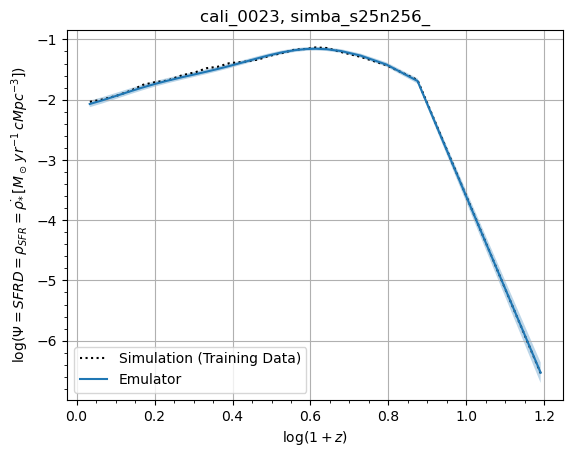

x:  [1.19045016 0.87206648 0.79649778 0.72452625 0.67963197 0.64079057
 0.61551593 0.59248199 0.56857689 0.54570672 0.52462811 0.50467739
 0.48317827 0.46260005 0.43606038 0.41541934 0.39677786 0.37517777
 0.34896968 0.32432403 0.30404172 0.2830028  0.26002915 0.24021057
 0.21235761 0.18368876 0.15075558 0.11669702 0.08455558 0.05391736
 0.02851208]
pred_y:  [-6.5268706  -1.62635222 -1.33283239 -1.13690772 -1.04716194 -0.99319284
 -0.97115732 -0.96022391 -0.95770636 -0.96292014 -0.97335876 -0.98723829
 -1.0054156  -1.02485348 -1.0512835  -1.07190656 -1.09007237 -1.11029186
 -1.1336283  -1.15484501 -1.17238853 -1.19137174 -1.2138862  -1.2355042
 -1.27032165 -1.3123812  -1.36860219 -1.4341624  -1.50000922 -1.56272385
 -1.61185421]
pred_yerr:  [0.16969407 0.04228402 0.03465271 0.02955881 0.02722548 0.02582232
 0.02524941 0.02496515 0.0248997  0.02503525 0.02530665 0.02566751
 0.0261401  0.02664547 0.02733264 0.02786882 0.02834112 0.02886681
 0.02947354 0.03002516 0.03048128 0.03097483 0.0

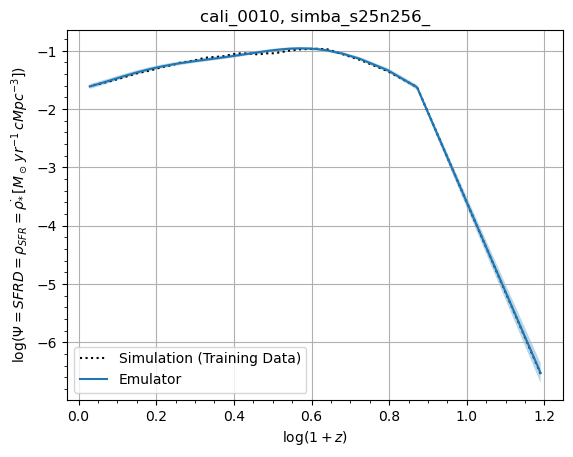

x:  [1.19045016 0.87321596 0.79864804 0.74401527 0.69547961 0.65741994
 0.62576686 0.59303563 0.55920113 0.53051622 0.49848734 0.46348024
 0.43753642 0.41297518 0.38583664 0.35108075 0.3226199  0.28844479
 0.25347988 0.22376103 0.19418687 0.15610109 0.11959685 0.0812478
 0.0461704  0.00912654]
pred_y:  [-6.42435543 -1.68150668 -1.44524331 -1.33744935 -1.2762605  -1.2530146
 -1.25209187 -1.26917423 -1.3047938  -1.34691805 -1.40316409 -1.47050927
 -1.52104398 -1.56738593 -1.61551537 -1.67145741 -1.71287202 -1.75925862
 -1.80608633 -1.84801738 -1.89347094 -1.95860166 -2.02690654 -2.10069391
 -2.16421844 -2.21993195]
pred_yerr:  [0.16702875 0.043718   0.03757532 0.03477275 0.03318188 0.0325775
 0.03255351 0.03299764 0.03392373 0.03501893 0.03648129 0.03823221
 0.03954608 0.04075094 0.04200227 0.04345672 0.04453347 0.04573949
 0.04695698 0.04804716 0.04922892 0.05092227 0.05269815 0.05461657
 0.05626817 0.05771668]


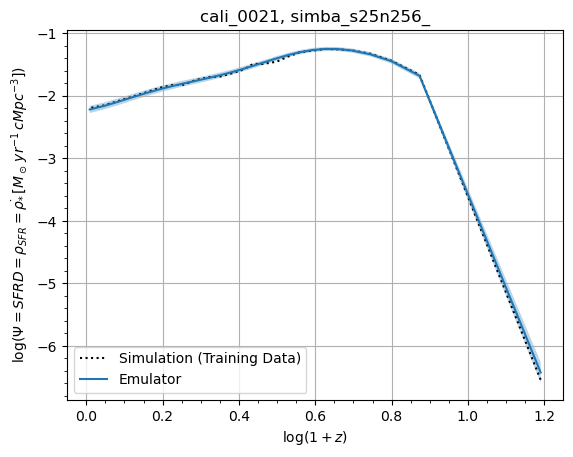

x:  [1.19045016 0.87370631 0.79482982 0.73897522 0.68987486 0.65154188
 0.61811233 0.58130062 0.54415733 0.5070281  0.47538106 0.44406357
 0.40785876 0.37347664 0.34015159 0.30609102 0.27703281 0.23820097
 0.2041665  0.17345189 0.13470295 0.09320087 0.05467697 0.01528899]
pred_y:  [-6.4526346  -1.66694977 -1.46186746 -1.38531935 -1.34988364 -1.34415421
 -1.35654194 -1.3892177  -1.4404119  -1.5054519  -1.56734839 -1.63044221
 -1.70154155 -1.76461869 -1.82104625 -1.87520446 -1.92054211 -1.98344189
 -2.0436666  -2.10343027 -2.1856874  -2.27825046 -2.36127059 -2.4342088 ]
pred_yerr:  [0.16776399 0.04333953 0.03800753 0.03601733 0.03509603 0.03494707
 0.03526914 0.03611869 0.0374497  0.0391407  0.04074996 0.04239036
 0.04423889 0.04587885 0.04734593 0.048754   0.04993275 0.0515681
 0.0531339  0.05468772 0.05682634 0.05923292 0.06139138 0.06328773]


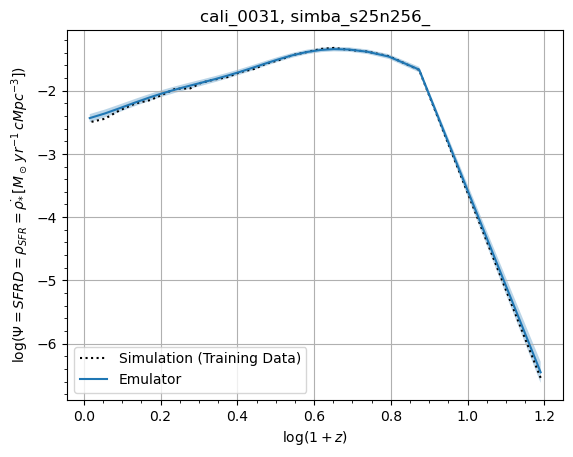

x:  [1.19045016 0.87068388 0.78986612 0.72066783 0.68136423 0.64811353
 0.61875941 0.59153146 0.56988513 0.5475877  0.52576153 0.50238796
 0.47707313 0.45391056 0.4298437  0.40428169 0.37695928 0.35221718
 0.32087759 0.2954281  0.27258508 0.24949888 0.23008925 0.20084465
 0.16814658 0.13611368 0.10401849 0.07517079 0.04637735 0.01143459]
pred_y:  [-6.53049576 -1.63699542 -1.33693865 -1.16372333 -1.09516996 -1.05702054
 -1.03991036 -1.03810466 -1.04580759 -1.06128098 -1.08264268 -1.11071698
 -1.14503607 -1.17802183 -1.21207984 -1.24639943 -1.27971773 -1.30646458
 -1.33611652 -1.35779155 -1.37655511 -1.39596171 -1.41338109 -1.44271081
 -1.48104355 -1.52439333 -1.57220989 -1.61669517 -1.65975887 -1.70590293]
pred_yerr:  [0.16978832 0.04256074 0.03475947 0.03025599 0.02847365 0.02748179
 0.02703694 0.02699    0.02719027 0.02759256 0.02814795 0.02887786
 0.02977014 0.03062774 0.03151323 0.03240551 0.03327177 0.03396717
 0.0347381  0.03530163 0.03578947 0.03629403 0.03674692 0.03750947
 0.03

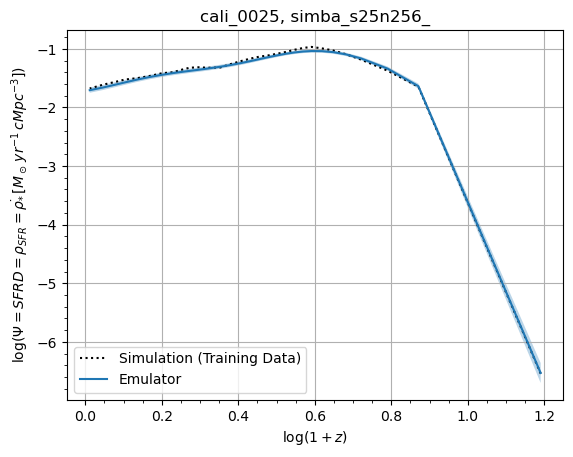

x:  [1.19045016 0.87214686 0.78956067 0.72615402 0.68396766 0.65178103
 0.61840773 0.58774136 0.55459113 0.52206387 0.4904128  0.45961379
 0.42635505 0.39689845 0.36216867 0.32794634 0.29883437 0.26340049
 0.23500572 0.20274372 0.16350042 0.1308405  0.09284818 0.05607467
 0.02025667]
pred_y:  [-6.61282872 -1.69373839 -1.45116831 -1.3408396  -1.29407621 -1.27451312
 -1.27064518 -1.28221895 -1.30991809 -1.34975107 -1.39685    -1.44672542
 -1.50105951 -1.54702145 -1.59693498 -1.64170824 -1.67770217 -1.72168326
 -1.75933414 -1.80683358 -1.8729671  -1.93452904 -2.01048259 -2.08308752
 -2.14642779]
pred_yerr:  [0.17192892 0.04403601 0.03772936 0.03486089 0.03364508 0.03313645
 0.03303589 0.0333368  0.03405695 0.03509258 0.03631712 0.03761385
 0.0390265  0.04022148 0.04151919 0.04268327 0.04361908 0.04476256
 0.04574146 0.04697641 0.04869583 0.0502964  0.05227114 0.05415882
 0.05580562]


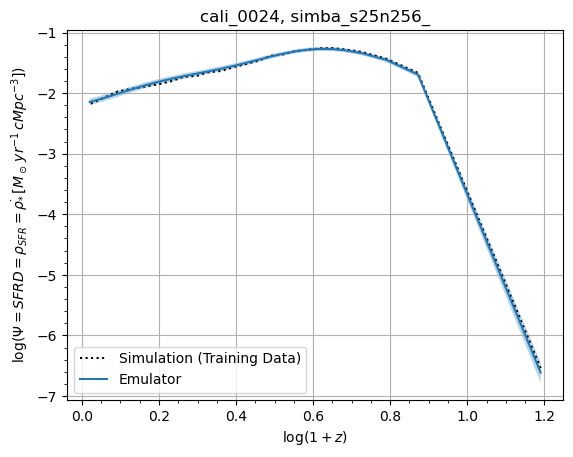

x:  [1.19045016 0.88312728 0.79471326 0.73866976 0.69197488 0.6564453
 0.62721778 0.60113831 0.57104567 0.54467179 0.51662994 0.4894482
 0.46042115 0.4285254  0.39582934 0.37207195 0.34788852 0.32037219
 0.29336225 0.25915296 0.22731298 0.19058469 0.15485513 0.12316789
 0.09230457 0.05735777 0.0223738 ]
pred_y:  [-6.4762103  -1.50588121 -1.17798079 -1.05377275 -0.98273682 -0.94829592
 -0.93343448 -0.93061315 -0.93910438 -0.95586481 -0.98159752 -1.01243631
 -1.04959068 -1.09306363 -1.13861858 -1.17188742 -1.20607213 -1.24608597
 -1.28768683 -1.34583138 -1.40748357 -1.48928174 -1.57970993 -1.66699558
 -1.75539245 -1.85465389 -1.94705093]
pred_yerr:  [0.16837694 0.03915186 0.03062668 0.02739735 0.02555047 0.02465503
 0.02426864 0.02419529 0.02441606 0.02485182 0.02552085 0.02632264
 0.02728862 0.02841889 0.02960329 0.03046825 0.03135703 0.03239736
 0.03347896 0.03499067 0.03659359 0.03872028 0.04107135 0.04334072
 0.04563898 0.0482197  0.05062196]


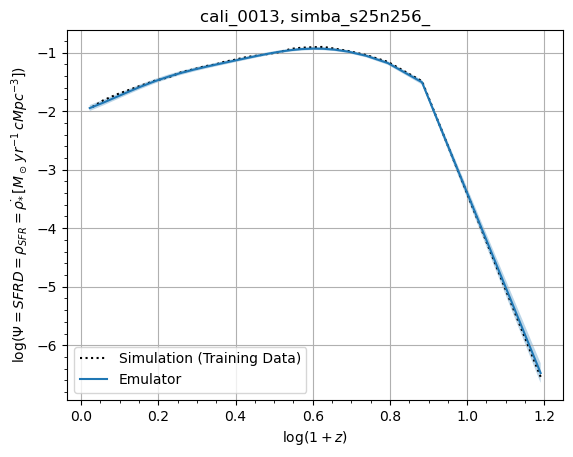

x:  [1.19045016 0.87335262 0.79573011 0.72726332 0.6842058  0.64402601
 0.61649661 0.59142696 0.56255113 0.53405712 0.50709041 0.48601883
 0.46379776 0.44030564 0.41559168 0.38826071 0.3654202  0.34275802
 0.32558203 0.30749371 0.28139311 0.25600192 0.22985312 0.20295674
 0.17751128 0.14890273 0.12077649 0.09362891 0.0669194  0.04672302
 0.01746838]
pred_y:  [-6.53833001 -1.66119737 -1.3585628  -1.16790794 -1.07671512 -1.01556176
 -0.98875032 -0.97534495 -0.97232183 -0.98083094 -0.9972716  -1.01424095
 -1.03465149 -1.05765725 -1.08210635 -1.10826577 -1.12899027 -1.14860498
 -1.1631012  -1.17838037 -1.2013165  -1.22584613 -1.25471157 -1.28931136
 -1.32716692 -1.37557066 -1.4282146  -1.48206788 -1.53576264 -1.57530087
 -1.62840666]
pred_yerr:  [0.16999201 0.04318997 0.03532168 0.03036479 0.02799384 0.0264039
 0.02570682 0.02535829 0.02527969 0.02550092 0.02592836 0.02636956
 0.02690022 0.02749835 0.02813401 0.02881413 0.02935296 0.02986293
 0.03023982 0.03063707 0.03123339 0.03187114 0.0

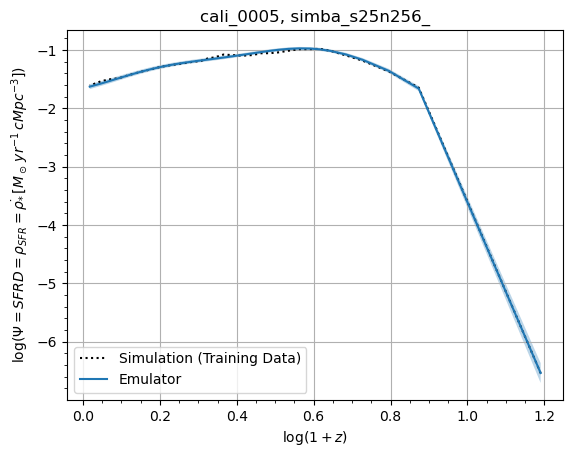

x:  [1.19045016 0.87370631 0.78989828 0.72403993 0.6790733  0.64921478
 0.62322071 0.59642279 0.56845933 0.54026274 0.51591051 0.49194762
 0.46991898 0.44185704 0.41191814 0.39109575 0.37005431 0.34427124
 0.31829527 0.29075983 0.25315635 0.21581109 0.18818623 0.15694111
 0.1257442  0.08994935 0.05421477 0.02442861]
pred_y:  [-6.55287395 -1.57587391 -1.30116934 -1.17119231 -1.11206873 -1.08689495
 -1.07486939 -1.0723139  -1.07990731 -1.09706417 -1.11823016 -1.14341112
 -1.16919577 -1.20411517 -1.24226747 -1.26872964 -1.29527141 -1.32776463
 -1.36118097 -1.39858929 -1.45570198 -1.52241592 -1.57936137 -1.65148109
 -1.73024447 -1.82533689 -1.91971834 -1.99310694]
pred_yerr:  [0.17037014 0.04097162 0.03382949 0.03045018 0.02891301 0.02825851
 0.02794585 0.02787941 0.02807683 0.0285229  0.0290732  0.02972789
 0.03039827 0.03130615 0.03229809 0.03298608 0.03367615 0.03452095
 0.03538975 0.03636234 0.03784723 0.03958175 0.04106229 0.04293735
 0.04498515 0.04745748 0.04991133 0.05181939]


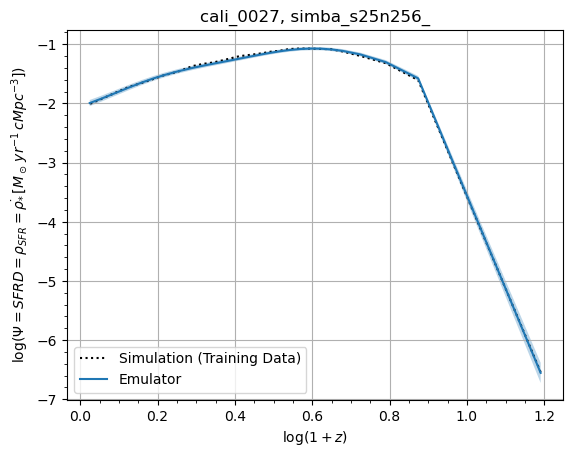

x:  [1.19045016 0.88770915 0.79792057 0.72897549 0.6746723  0.62938413
 0.59555466 0.56100977 0.52909543 0.49758302 0.46770039 0.43455418
 0.39515011 0.35265074 0.32990267 0.30068118 0.25960714 0.22755816
 0.18202884 0.14618576 0.10902035 0.06438329 0.02022857]
pred_y:  [-6.3820401  -1.39767257 -1.05001958 -0.90483307 -0.8374033  -0.81196613
 -0.81176564 -0.82743391 -0.85449093 -0.89079411 -0.93178461 -0.9823815
 -1.04719683 -1.12194198 -1.16458433 -1.22320234 -1.31549502 -1.39753048
 -1.53057461 -1.64745686 -1.77575791 -1.93040363 -2.07137828]
pred_yerr:  [0.16592858 0.03633851 0.02729977 0.02352503 0.0217719  0.02111055
 0.02110534 0.0215127  0.02221617 0.02316002 0.02422575 0.02554123
 0.02722639 0.02916971 0.03027838 0.03180241 0.03420195 0.03633482
 0.03979387 0.04283273 0.04616846 0.05018914 0.05385439]


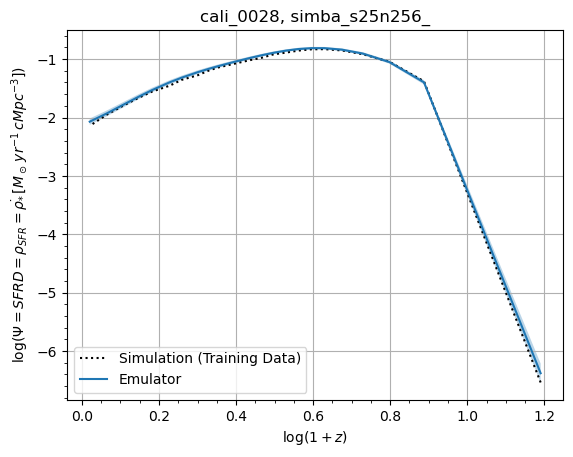

x:  [1.19045016 0.89022515 0.8050506  0.74287081 0.69235269 0.64996235
 0.61390625 0.57924279 0.54658793 0.51324177 0.4786366  0.44099291
 0.41406841 0.3863521  0.35663677 0.32388997 0.29001628 0.2611706
 0.22904124 0.19179546 0.15433166 0.11460301 0.07719244 0.03409073]
pred_y:  [-6.41109096 -1.44573842 -1.11831009 -0.98973334 -0.92771173 -0.90278194
 -0.90152618 -0.91722828 -0.94568592 -0.98589393 -1.03614713 -1.09661079
 -1.14165153 -1.18873321 -1.23997542 -1.2982688  -1.36252411 -1.42224954
 -1.49595011 -1.59216878 -1.70017396 -1.82353767 -1.94210164 -2.07177578]
pred_yerr:  [0.16668388 0.03758819 0.02907528 0.02573237 0.02411986 0.0234717
 0.02343905 0.02384729 0.02458717 0.02563255 0.0269391  0.02851111
 0.02968214 0.03090623 0.03223849 0.03375408 0.03542467 0.03697749
 0.03889366 0.04139527 0.04420333 0.0474107  0.05049328 0.05386472]


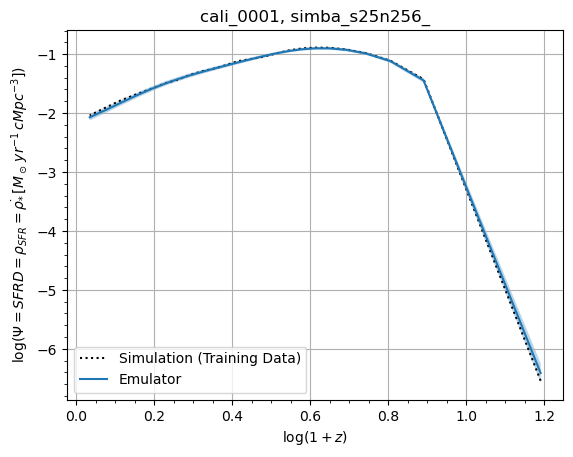

x:  [1.19045016 0.87775764 0.79907809 0.72614598 0.67485315 0.64216111
 0.62053589 0.59699352 0.57064978 0.54150467 0.51319354 0.48430364
 0.45650295 0.4234974  0.39756764 0.37380421 0.34800206 0.31715281
 0.28878642 0.25729611 0.22849865 0.19730173 0.1656537  0.1410211
 0.11109828 0.07382436 0.03830384 0.00524904]
pred_y:  [-6.51813158 -1.55148428 -1.2628586  -1.09508275 -1.01476976 -0.98084759
 -0.96644303 -0.95819746 -0.95792399 -0.96772308 -0.98584749 -1.01106159
 -1.03976643 -1.07723393 -1.10812869 -1.13725006 -1.16994762 -1.21146056
 -1.25339062 -1.30609218 -1.36149295 -1.43031134 -1.50945901 -1.57672579
 -1.66315428 -1.7734304  -1.87476076 -1.95955777]
pred_yerr:  [0.16946686 0.04033751 0.03283344 0.02847139 0.0263833  0.02550135
 0.02512684 0.02491246 0.02490535 0.02516012 0.02563135 0.02628689
 0.0270332  0.02800733 0.02881057 0.02956771 0.03041782 0.03149713
 0.03258728 0.03395748 0.03539786 0.03718709 0.03924488 0.04099377
 0.04324085 0.04610795 0.04874247 0.05094713]


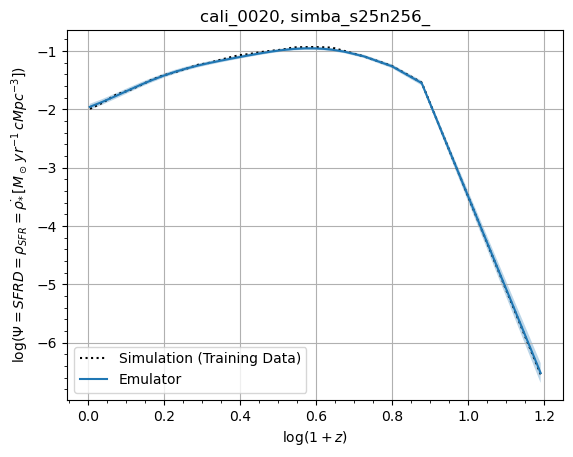

x:  [1.19045016 0.87239605 0.8002316  0.74396705 0.69737666 0.66222086
 0.63121285 0.60099663 0.57327632 0.54543341 0.51570151 0.48692214
 0.46119132 0.42903182 0.40503729 0.37678845 0.35221718 0.32409695
 0.29585617 0.27214599 0.24538426 0.21283388 0.18894987 0.16092009
 0.12826825 0.10145224 0.06864063 0.03594758 0.00256625]
pred_y:  [-6.59145023 -1.65307573 -1.40911206 -1.28416027 -1.21105937 -1.17526134
 -1.15913198 -1.15795949 -1.16908479 -1.19069043 -1.22296074 -1.26034022
 -1.2963789  -1.34179583 -1.37431551 -1.41002147 -1.43862563 -1.46909552
 -1.4985229  -1.52360485 -1.55381271 -1.59524188 -1.62986678 -1.67540905
 -1.73443627 -1.78620327 -1.85050335 -1.91139545 -1.96528683]
pred_yerr:  [0.1713731  0.04297881 0.03663593 0.03338727 0.0314867  0.03055597
 0.03013662 0.03010614 0.03039539 0.03095712 0.03179612 0.03276796
 0.03370494 0.03488575 0.03573124 0.03665957 0.03740326 0.03819546
 0.03896055 0.03961266 0.04039804 0.04147517 0.0423754  0.04355946
 0.04509413 0.04644004 0.048

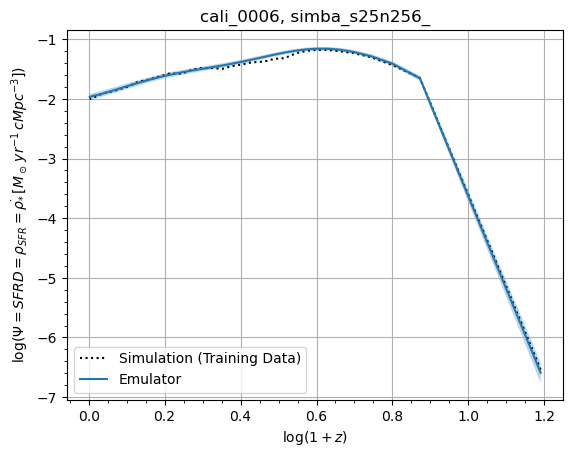

x:  [1.19045016 0.87304716 0.79303324 0.73421651 0.68648065 0.65103145
 0.61864487 0.58132975 0.54480241 0.51099504 0.47320265 0.43563937
 0.4045791  0.37674626 0.34435967 0.31081757 0.28182922 0.25155369
 0.21716455 0.18638565 0.14873391 0.11163084 0.0755928  0.03932971]
pred_y:  [-6.59534453 -1.68992158 -1.46210352 -1.36857546 -1.32628823 -1.31620789
 -1.3244355  -1.35459703 -1.40313983 -1.46055784 -1.53245488 -1.6048891
 -1.66121155 -1.70706823 -1.75435105 -1.79740182 -1.83161299 -1.86673934
 -1.90881513 -1.95046349 -2.00761509 -2.06933191 -2.13069368 -2.18830015]
pred_yerr:  [0.17147435 0.04393678 0.03801367 0.035582   0.03448257 0.03422048
 0.0344344  0.03521858 0.03648065 0.03797348 0.03984276 0.04172599
 0.04319034 0.04438258 0.0456119  0.04673119 0.04762066 0.04853392
 0.04962786 0.05071069 0.05219659 0.05380118 0.05539655 0.05689427]


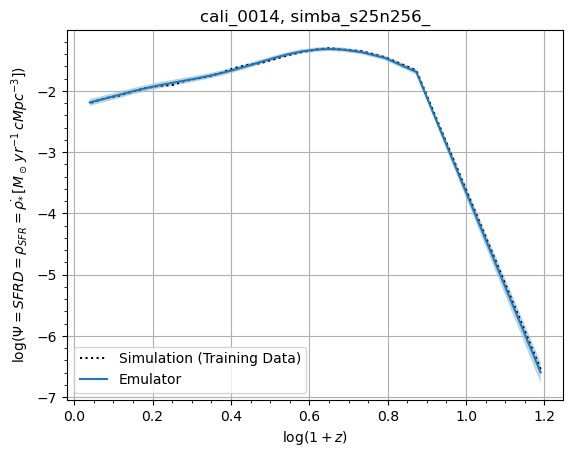

In [444]:
# Make predictions with trained emulator (but now with emulator uncertainties!) to compare to input

for cali in emulator.model_parameters.model_parameters:
    pred_params = emulator.model_parameters[cali]
    pred_x = emulator.model_values[cali]['independent']
    sim_y = emulator.model_values[cali]['dependent']
    sim_yerr = emulator.model_values[cali]['dependent_error']
    
    pred_y, pred_err = emulator_model(pred_x, pred_params, emulator)

    print("x: ", pred_x)
    print("pred_y: ", pred_y)
    print("pred_yerr: ", pred_err) 

    plt.clf()
    plt.xlabel(sim_info['X_LABEL'])
    plt.ylabel(sim_info['Y_LABEL'])
    plt.title(r'%s, %s_%s' % (cali, snap_prefix, snap_num))
    plt.grid()
    plt.minorticks_on()
#     plt.errorbar(pred_x, sim_y, yerr=sim_yerr, color="black", ls=":", label="Simulation (Training Data)")
    plt.errorbar(pred_x, sim_y, color="black", ls=":", label="Simulation (Training Data)")
#     plt.fill_between(pred_x, sim_y-sim_yerr, sim_y+sim_yerr, color='black', alpha=0.2)
#     plt.errorbar(pred_x, pred_y, yerr=pred_err, ls='-', label='Emulator')
    plt.errorbar(pred_x, pred_y, yerr=None, ls='-', label='Emulator')
    plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.3)
    plt.legend()
    plt.show()

## Sweeps of parameter space

In [483]:
# Get full range of x values that have been used in training emulator

sim_x = []
for cali in emulator.model_values.model_values:
    sim_x_curr = emulator.model_values[cali]['independent']
    for x_val in sim_x_curr:
        if x_val not in sim_x:
            sim_x.append(x_val)
            
sim_x = np.array(np.sort(sim_x))
print(sim_x)

[ 8.66666667  9.33333333 10.         10.66666667 11.33333333 12.
 12.66666667]


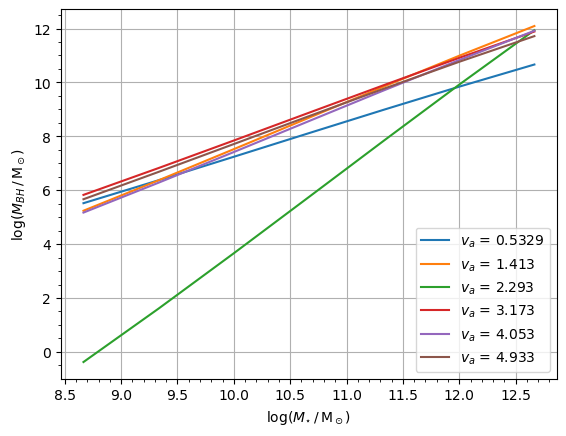

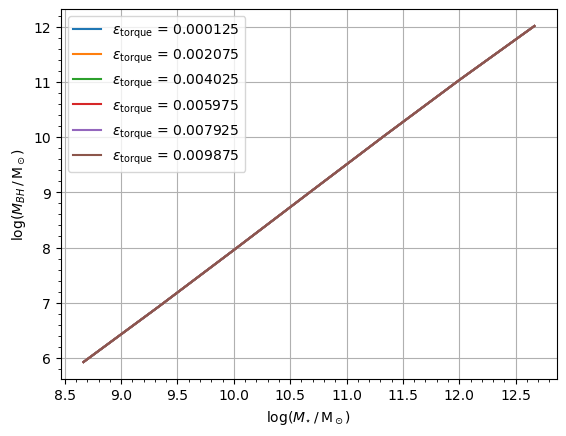

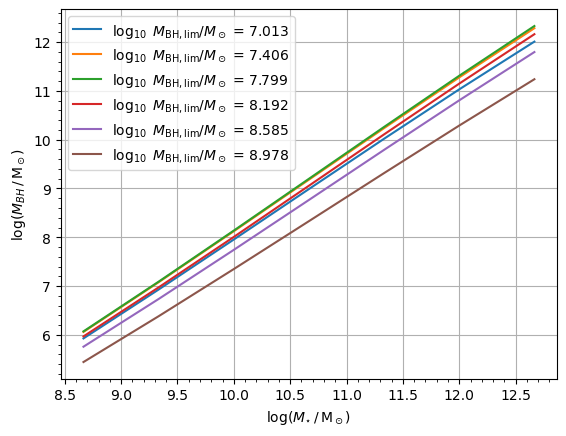

In [484]:
# Arbitrarily choose initial parameters to sweep from
# Doesn't matter too much though, because it ends up covering
# roughly the entire range of parameters used

centre = emulator.model_parameters['cali_0000']

# param_printable_names = []
for ii in range(len(emulator.parameter_order)):
    param_name = emulator.parameter_order[ii]
    param_printable_name = emulator.model_specification.parameter_printable_names[ii]
#     param_printable_names.append(param_printable_name)
    
    Mock_values, Mock_parameters = mock_sweep(emulator, emulator.model_specification, 6, param_name, centre)

    plt.clf()
    
    for mock_name in Mock_values.keys():
        plt.plot(Mock_values[mock_name]["independent"],
                Mock_values[mock_name]["dependent"],
                label = "%s = %.4g" % (param_printable_name, Mock_parameters[mock_name][param_name]))
    
    plt.xlabel(sim_info['X_LABEL'])
    plt.ylabel(sim_info['Y_LABEL'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()

## Checking hyperparameters (doesn't always work)

In [449]:
emulator.kernel.get_parameter_dict(include_frozen=True)

OrderedDict([('k1:log_constant', -1.3862943611198906),
             ('k2:metric:log_M_0_0', 0.0),
             ('k2:metric:log_M_1_1', 0.0),
             ('k2:metric:log_M_2_2', 0.0),
             ('k2:metric:log_M_3_3', 0.0)])

In [450]:
emulator_mcmc = gaussian_process_mcmc.GaussianProcessEmulatorMCMC(burn_in_steps=1, mcmc_steps=1000)#, hide_progress=False)
emulator_mcmc.fit_model(model_specification=model_specification,
                        model_parameters=model_parameters,
                        model_values=model_values)

In [451]:
emulator_mcmc.kernel.get_parameter_dict(include_frozen=True)

OrderedDict([('k1:log_constant', -1.3862943611198906),
             ('k2:metric:log_M_0_0', 0.0),
             ('k2:metric:log_M_1_1', 0.0),
             ('k2:metric:log_M_2_2', 0.0),
             ('k2:metric:log_M_3_3', 0.0)])

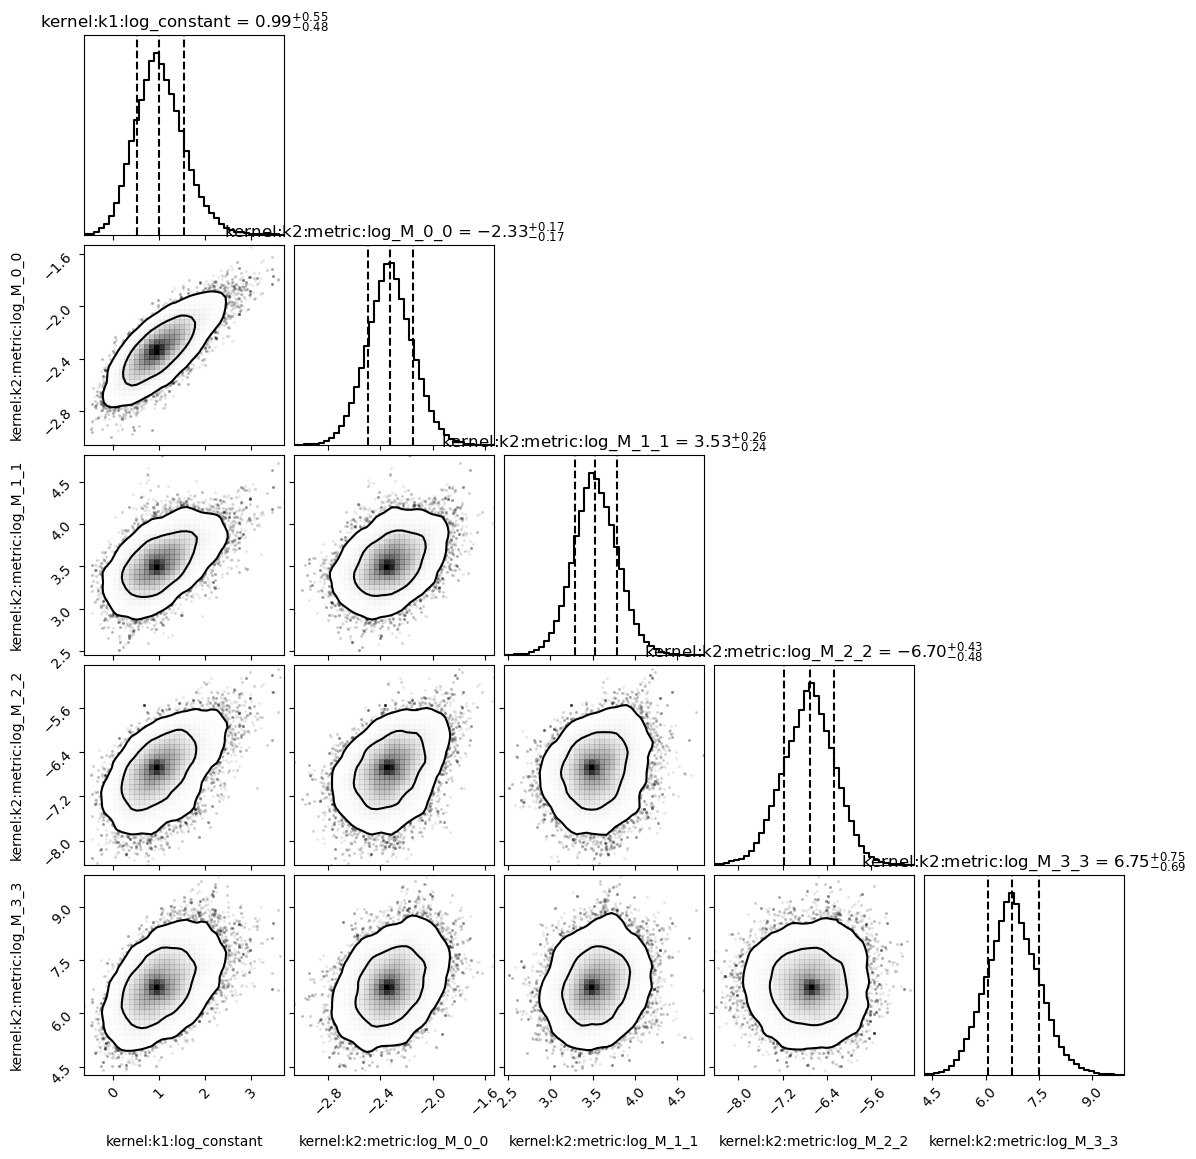

In [452]:
emulator_mcmc.plot_hyperparameter_distribution()

## Save emulator to pickle file with dill module

In [447]:
def save_object(obj, filename):
    with open(filename, 'wb') as f:  # Overwrites any existing file.
        dill.dump(obj, f, dill.HIGHEST_PROTOCOL)

In [448]:
emulator_filename = 'emulator_'+obs_name+'.pkl'
emulator_path = os.path.join(root_dir, 'emulators')
if not os.path.isdir(emulator_path):
    os.makedirs(emulator_path, mode = 0o755, exist_ok=True)
save_object(emulator, os.path.join(emulator_path, emulator_filename))